# **Libraries**

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
from datetime import datetime

# **Functions**

## Helper Functions

In [2]:
# LOAD PORTFOLIO STATES
def load_portfolio_states(portfolio_names, start_date, end_date, db_path="aipm_thesis.db"):
    """
    Load and unpack portfolio states for given portfolio_names between start_date and end_date.
    Returns a DataFrame with columns:
      - portfolio_name (str)
      - date           (datetime64[ns])
      - ticker         (str)
      - shares         (float)
    """
    conn = sqlite3.connect(db_path)
    placeholders = ", ".join("?" for _ in portfolio_names)
    query = f"""
    SELECT portfolio_name, date, state
    FROM portfolio
    WHERE portfolio_name IN ({placeholders})
      AND date BETWEEN ? AND ?
    ORDER BY portfolio_name, date
    """
    params = portfolio_names + [start_date, end_date]
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()

    records = []
    for _, row in df.iterrows():
        state = json.loads(row["state"])
        rebalance_date = pd.to_datetime(state["date"])
        for alloc in state["allocations"]:
            records.append({
                "portfolio_name": row["portfolio_name"],
                "date":           rebalance_date,
                "ticker":         alloc["ticker"],
                "shares":         alloc["stocks"],
            })

    return pd.DataFrame(records)

In [3]:
# LOAD PRICE DATA
def load_price_data(tickers, start_date, end_date, agg="monthly", db_path='aipm_thesis.db'):
    """
    Load daily close prices for the given tickers and date range,
    extend the raw data window backwards by one period (month or quarter)
    so that rebalance dates on the first day have a prior-period price,
    aggregate to month- or quarter-end, shift forward one day,
    and normalize to midnight so it lines up exactly with portfolio dates.
    
    Returns a DataFrame with:
      - ticker (str)
      - date   (datetime64[ns])  ← period end + 1 day, normalized to 00:00:00
      - close  (float)
    """
    # Determine the raw SQL start to include one prior period
    dt_start = pd.to_datetime(start_date)
    if agg == "monthly":
        raw_start = (dt_start - pd.DateOffset(months=1)).strftime("%Y-%m-%d")
    elif agg == "quarterly":
        raw_start = (dt_start - pd.DateOffset(months=3)).strftime("%Y-%m-%d")
    else:
        raise ValueError("agg must be 'monthly' or 'quarterly'")
    
    conn = sqlite3.connect(db_path)
    placeholders = ", ".join("?" for _ in tickers)
    query = f"""
    SELECT ticker, date, close
    FROM stock_prices_daily
    WHERE ticker IN ({placeholders})
      AND date BETWEEN ? AND ?
    """
    params = tickers + [raw_start, end_date]
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()

    # Convert to Timestamp
    df["date"] = pd.to_datetime(df["date"])

    # Determine period ends
    if agg == "monthly":
        period_end = df["date"].dt.to_period("M").dt.to_timestamp(how="end")
    else:  # quarterly
        period_end = df["date"].dt.to_period("Q").dt.to_timestamp(how="end")

    # Shift + normalize for rebalance alignment
    df["date"] = (period_end + pd.Timedelta(days=1)).dt.normalize()

    # Aggregate by last close for each ticker & date
    price_df = (
        df
        .groupby(["ticker", "date"], as_index=False)
        .agg(close=("close", "last"))
    )

    return price_df

In [4]:
# INFER ANNUALIZATION FACTOR
def infer_annualization_factor(dates: pd.Series) -> float:
    """
    Infer periods-per-year from a series of dates.
    Tries pandas.infer_freq, then falls back to (365 / avg_days_between).
    """
    idx = pd.DatetimeIndex(dates.sort_values().unique())
    freqstr = pd.infer_freq(idx)
    if freqstr:
        if freqstr.startswith("Q"):
            return 4.0
        if freqstr.startswith("M"):
            return 12.0
        if freqstr in ("B", "C", "D"):
            return 252.0
    # fallback: average days between points
    if len(idx) > 1:
        deltas = np.diff(idx.values.astype("datetime64[D]").astype(float))
        avg_days = deltas.mean()
        return 365.0 / avg_days
    return 1.0

In [5]:
# COMPUTE PORTFOLIO VALUES
def compute_portfolio_values(portfolio_df, price_df):
    """
    Merge portfolio share counts with price data and compute NAV,
    but only keep the dates for which we have price data.
    
    Returns a DataFrame with columns:
      - portfolio_name (str)
      - date           (datetime64[ns])
      - total_value    (float)
    """
    # 1) Merge shares & closes
    merged = pd.merge(
        portfolio_df,
        price_df,
        on=["ticker", "date"],
        how="left",
        validate="many_to_one"
    )
    merged["value_at_close"] = merged["shares"] * merged["close"]
    
    # 2) Compute NAV
    nav = (
        merged
        .groupby(["portfolio_name", "date"], as_index=False)
        .agg(total_value=("value_at_close", "sum"))
    )
    
    # 3) Drop any dates where close was missing (these became NaN or 0)
    valid_dates = price_df["date"].unique()
    nav = nav[nav["date"].isin(valid_dates)].reset_index(drop=True)
    
    return nav

In [6]:
# COMPUTE CUMULATIVE RETURNS
def compute_cumulative_returns(portfolio_values_df):
    """
    From NAV time-series, compute cumulative returns:
      cumulative_return = total_value / initial_value - 1
    """
    df = portfolio_values_df.copy().sort_values(["portfolio_name", "date"])
    df["initial_value"] = df.groupby("portfolio_name")["total_value"].transform("first")
    df["cumulative_return"] = df["total_value"] / df["initial_value"] - 1
    return df

In [7]:
# LOAD PORTFOLIO FEES
def load_portfolio_fees(
    portfolio_names,
    start_date,
    end_date,
    db_path="aipm_thesis.db"
):
    """
    Returns a DataFrame with columns:
      - portfolio_name
      - date (datetime)
      - transaction_fees (float)
      - portfolio_value  (float)
    by unpacking the `state` JSON from the portfolio table.
    """
    conn = sqlite3.connect(db_path)
    placeholders = ",".join("?" for _ in portfolio_names)
    qry = f"""
      SELECT portfolio_name, date, state
      FROM portfolio
      WHERE portfolio_name IN ({placeholders})
        AND date BETWEEN ? AND ?
      ORDER BY portfolio_name, date
    """
    params = portfolio_names + [start_date, end_date]
    raw = pd.read_sql_query(qry, conn, params=params)
    conn.close()

    rows = []
    for _, r in raw.iterrows():
        st = json.loads(r["state"])
        rows.append({
            "portfolio_name":    r["portfolio_name"],
            "date":              pd.to_datetime(st["date"]),
            "transaction_fees":  st.get("transaction_fees", 0.0),
            "portfolio_value":   st.get("portfolio_value", 0.0)
        })
    return pd.DataFrame(rows)

In [8]:
# LOAD AND PARSE RETRIES
def load_portfolio_retries(
    portfolio_names, start_date, end_date, db_path="aipm_thesis.db"
):
    """
    Loads portfolio notes and extracts retry counts per rebalance.
    Returns DataFrame with:
      - portfolio_name
      - date (datetime)
      - retries (int)
    """
    conn = sqlite3.connect(db_path)
    placeholders = ",".join("?" for _ in portfolio_names)
    query = f"""
      SELECT portfolio_name, date, notes
      FROM portfolio
      WHERE portfolio_name IN ({placeholders})
        AND date BETWEEN ? AND ?
      ORDER BY portfolio_name, date
    """
    params = portfolio_names + [start_date, end_date]
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()

    # parse retries from notes, default 0
    retry_list = []
    for _, row in df.iterrows():
        notes = row['notes'] or ""
        m = re.search(r"Retries:\s*(\d+)", notes)
        retries = int(m.group(1)) if m else 0
        retry_list.append(retries)

    df['date'] = pd.to_datetime(df['date'])
    df['retries'] = retry_list
    return df[['portfolio_name','date','retries']]

## Cumulative Returns & Value

In [9]:
# PLOT CUMULATIVE RETURNS
def plot_cumulative_returns(cumulative_returns_df, benchmark_df=None):
    """
    Plot cumulative returns for each portfolio, plus an optional benchmark,
    with major gridlines and rotated x-axis labels.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each portfolio’s cumulative return
    for name, grp in cumulative_returns_df.groupby("portfolio_name"):
        ax.plot(grp["date"], grp["cumulative_return"], label=name, linewidth=2)
    
    # Optional benchmark line
    if benchmark_df is not None:
        bm = benchmark_df.sort_values("date")
        bm_label = bm["ticker"].iloc[0]
        ax.plot(
            bm["date"],
            bm["cumulative_return"],
            label=bm_label,
            linestyle="--",
            color="black",
            linewidth=2
        )
    
    # Add major gridlines
    ax.grid(which="major", linestyle="--", linewidth=0.5)
    
    # Rotate x-labels at the actual dates
    dates = sorted(cumulative_returns_df["date"].unique())
    ax.set_xticks(dates)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates],
                       rotation=45, ha="right")
    
    ax.set_title("Cumulative Returns", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Cumulative Return", fontsize=12)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [10]:
# PLOT PORTFOLIO VALUES
def plot_portfolio_values(portfolio_values_df, benchmark_price_df=None):
    """
    Plot NAV over time for each portfolio (and optional benchmark),
    labeling the x-axis only at the rebalance dates.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each portfolio
    for name, grp in portfolio_values_df.groupby("portfolio_name"):
        ax.plot(grp["date"], grp["total_value"], label=name, linewidth=2)

    # Plot scaled benchmark if provided
    if benchmark_price_df is not None:
        # Scale SPY to portfolio's starting NAV
        first_nav = portfolio_values_df.sort_values("date")\
                     .groupby("portfolio_name")["total_value"].first().iloc[0]
        bm = benchmark_price_df.sort_values("date").copy()
        spy_first = bm["close"].iloc[0]
        bm["scaled_close"] = bm["close"] * (first_nav / spy_first)
        
        ax.plot(
            bm["date"],
            bm["scaled_close"],
            label=bm["ticker"].iloc[0],
            linestyle="--",
            color="black",
            linewidth=2
        )
    
    # Only show ticks at the actual dates
    dates = sorted(portfolio_values_df["date"].unique())
    ax.set_xticks(dates)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates], rotation=45, ha="right")
    
    ax.grid(which="major", linestyle="--", linewidth=0.5)
    ax.set_title("Portfolio Value Over Time", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Portfolio Value (USD)", fontsize=12)
    ax.legend()
    fig.tight_layout()
    plt.show()


In [11]:
# ANALYZE AND PLOT CUMULATIVE RETURNS
def analyze_and_plot_cumulative_returns(
    portfolio_names,
    start_date,
    end_date,
    aggregation="monthly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
):
    """
    Load data, compute NAV and cumulative returns for each portfolio vs. benchmark,
    and plot the cumulative-return chart.
    
    Returns:
      - portfolio_cumret_df : pd.DataFrame
      - benchmark_price_df  : pd.DataFrame
    """
    # Load portfolio allocations
    portfolio_df = load_portfolio_states(
        portfolio_names=portfolio_names,
        start_date=start_date,
        end_date=end_date,
        db_path=db_path
    )

    # Load and prepare benchmark prices & cum returns
    benchmark_price_df = load_price_data(
        tickers=[benchmark_ticker],
        start_date=start_date,
        end_date=end_date,
        agg=aggregation,
        db_path=db_path
    ).sort_values("date")
    benchmark_price_df["initial_price"] = (
        benchmark_price_df.groupby("ticker")["close"].transform("first")
    )
    benchmark_price_df["cumulative_return"] = (
        benchmark_price_df["close"] / benchmark_price_df["initial_price"] - 1
    )

    # Load portfolio tickers’ prices
    tickers = portfolio_df["ticker"].unique().tolist()
    price_df = load_price_data(
        tickers=tickers,
        start_date=start_date,
        end_date=end_date,
        agg=aggregation,
        db_path=db_path
    )

    # Compute NAV & cum returns
    portfolio_values_df = compute_portfolio_values(
        portfolio_df=portfolio_df,
        price_df=price_df
    )
    portfolio_cumret_df = compute_cumulative_returns(portfolio_values_df)

    # Plot
    plot_cumulative_returns(
        cumulative_returns_df=portfolio_cumret_df,
        benchmark_df=benchmark_price_df
    )

    return portfolio_cumret_df, benchmark_price_df

In [12]:
# ANALYZE AND PLOT PORTFOLIO VALUES
def analyze_and_plot_portfolio_values(
    portfolio_names,
    start_date,
    end_date,
    aggregation="monthly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
):
    """
    Load data, compute NAV for each portfolio vs. benchmark,
    and plot the NAV chart with scaled benchmark overlay.
    
    Returns:
      - portfolio_values_df : pd.DataFrame
      - benchmark_price_df  : pd.DataFrame
    """
    # Load portfolio allocations
    portfolio_df = load_portfolio_states(
        portfolio_names=portfolio_names,
        start_date=start_date,
        end_date=end_date,
        db_path=db_path
    )

    # Load and prepare benchmark prices
    benchmark_price_df = load_price_data(
        tickers=[benchmark_ticker],
        start_date=start_date,
        end_date=end_date,
        agg=aggregation,
        db_path=db_path
    ).sort_values("date")

    # Load portfolio tickers’ prices
    tickers = portfolio_df["ticker"].unique().tolist()
    price_df = load_price_data(
        tickers=tickers,
        start_date=start_date,
        end_date=end_date,
        agg=aggregation,
        db_path=db_path
    )

    # Compute NAV
    portfolio_values_df = compute_portfolio_values(
        portfolio_df=portfolio_df,
        price_df=price_df
    )

    # Plot
    plot_portfolio_values(
        portfolio_values_df=portfolio_values_df,
        benchmark_price_df=benchmark_price_df
    )

    return portfolio_values_df, benchmark_price_df

## Portfolio Allocation

In [13]:
# COMPUTE PORTFOLIO ALLOCATION OVER TIME
def compute_portfolio_allocation_over_time(
    portfolio_name,
    start_date,
    end_date,
    agg="monthly",
    db_path="aipm_thesis.db"
):
    """
    Returns a DataFrame of:
      date, ticker, allocation_pct
    for a single portfolio, at the given frequency,
    with CASH handled as price=1.
    """
    # 1) Load share counts
    pf = load_portfolio_states(
        portfolio_names=[portfolio_name],
        start_date=start_date,
        end_date=end_date,
        db_path=db_path
    )
    # 2) Load prices at agg frequency
    tickers = pf["ticker"].unique().tolist()
    price_df = load_price_data(
        tickers=[t for t in tickers if t != "CASH"],
        start_date=start_date,
        end_date=end_date,
        agg=agg,
        db_path=db_path
    )
    # 2b) Inject CASH as price=1 for every rebalance date
    if "CASH" in tickers:
        cash_dates = pf["date"].unique()
        cash_df = pd.DataFrame({
            "ticker": "CASH",
            "date":    pd.to_datetime(cash_dates),
            "close":   1.0
        })
        price_df = pd.concat([price_df, cash_df], ignore_index=True)
    
    # 3) Merge & compute value per ticker
    df = pd.merge(
        pf, price_df,
        on=["ticker", "date"],
        how="left",
        validate="many_to_one"
    )
    df["value_at_close"] = df["shares"] * df["close"]

    # 4) Total NAV per date
    nav = (
        df
        .groupby("date", as_index=False)
        .agg(nav=("value_at_close", "sum"))
    )
    df = df.merge(nav, on="date", how="left")

    # 5) Compute pct allocation
    df["allocation_pct"] = df["value_at_close"] / df["nav"]

    return df[["date", "ticker", "allocation_pct"]]


In [14]:
# PLOT PORTFOLIO ALLOCATION OVER TIME
def plot_portfolio_allocation_over_time(
    alloc_df,
    top_n=10,
    title="Portfolio Allocation Over Time"
):
    """
    Stacked-area: top_n tickers + Other at bottom (gray=#888888),
    with Tab20 palette for the tickers.
    """
    # 1) Identify top_n tickers
    avg = alloc_df.groupby("ticker")["allocation_pct"]\
                  .mean()\
                  .sort_values(ascending=False)
    top_tickers = set(avg.head(top_n).index)

    # 2) Label Others
    df = alloc_df.copy()
    df["group"] = df["ticker"].where(df["ticker"].isin(top_tickers), "Other")

    # 3) Pivot & sum Other
    pivot = (
        df.pivot_table(
             index="date",
             columns="group",
             values="allocation_pct",
             aggfunc="sum"
         )
         .fillna(0)
    )

    # 4) Reorder so Other is first
    ordered = ["Other"] + [t for t in avg.index if t in top_tickers]
    cols = [c for c in ordered if c in pivot.columns]
    pivot = pivot[cols]

    # 5) Build colors: Other→gray, tickers→Tab20
    tab20 = plt.get_cmap("tab20").colors
    # Exclude any grays if present
    ticker_colors = [c for c in tab20 if not np.allclose(c, (0.5,0.5,0.5))][:len(cols)-1]
    colors = ["#B0B0B0"] + ticker_colors  # Other first

    # 6) Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot.plot.area(ax=ax, color=colors, linewidth=0)

    # 7) X‐ticks only at actual dates
    dates = list(pivot.index)
    ax.set_xticks(dates)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates],
                       rotation=45, ha="right")

    # 8) Styling
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Allocation (%)", fontsize=12)
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
    ax.grid(which="major", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [15]:
# COMPUTE AVERAGE SECTOR ALLOCATION
def compute_average_sector_allocation(
    allocation_df,
    db_path="aipm_thesis.db"
):
    """
    Given ticker‐level allocation_df (date, ticker, allocation_pct),
    returns DataFrame of:
      sector, average_allocation_pct
    """
    # Load sector info
    conn = sqlite3.connect(db_path)
    sector_df = pd.read_sql_query(
        "SELECT ticker, sector FROM sector_information",
        conn
    )
    conn.close()
    # Merge in sector
    df = allocation_df.merge(sector_df, on="ticker", how="left")
    # Sum to sector weights per date
    sec_weights = (
        df
        .groupby(["date","sector"], as_index=False)
        .agg(sector_pct=("allocation_pct","sum"))
    )
    # Average across dates
    avg = (
        sec_weights
        .groupby("sector", as_index=False)
        .agg(avg_allocation_pct=("sector_pct","mean"))
        .sort_values("avg_allocation_pct", ascending=False)
    )
    return avg


In [16]:
# PLOT AVERAGE SECTOR ALLOCATION
def plot_average_sector_allocation(
    avg_sector_df,
    title="Average Portfolio Allocation by Sector"
):
    """
    Bar chart of avg_sector_df:
      columns: sector, avg_allocation_pct
    """
    fig, ax = plt.subplots(figsize=(8,6))
    
    # 1) Plot bars using categorical x
    ax.bar(avg_sector_df["sector"], avg_sector_df["avg_allocation_pct"])
    
    # 2) Explicitly set xticks to positions 0..n-1
    ax.set_xticks(range(len(avg_sector_df)))
    
    # 3) Label them with sector names, rotated cleanly
    ax.set_xticklabels(avg_sector_df["sector"], rotation=45, ha="right")
    
    # 4) Titles and grid
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Sector", fontsize=12)
    ax.set_ylabel("Avg Allocation (%)", fontsize=12)
    ax.grid(axis="y", linestyle="--", linewidth=0.5)
    
    # 5) Tight layout
    plt.tight_layout()
    plt.show()

In [17]:
# COMPUTE AVERAGE SECTOR ALLOCATION FOR MULTIPLE PORTFOLIOS
def compute_average_sector_allocation_multiple(
    portfolio_names,
    start_date,
    end_date,
    agg="monthly",
    db_path="aipm_thesis.db"
):
    """
    For each portfolio in `portfolio_names`, compute its average
    sector allocation over time.

    Returns a DataFrame with columns:
      - portfolio_name
      - sector
      - avg_allocation_pct (0–1)
    """
    # 1) load ticker→sector mapping
    conn = sqlite3.connect(db_path)
    sector_lookup = pd.read_sql_query(
        "SELECT ticker, sector FROM sector_information", conn
    )
    conn.close()

    rows = []
    for pname in portfolio_names:
        # 2) get ticker-level allocations over time
        alloc = compute_portfolio_allocation_over_time(
            portfolio_name=pname,
            start_date=start_date,
            end_date=end_date,
            agg=agg,
            db_path=db_path
        )
        # 3) merge in sectors
        df = alloc.merge(sector_lookup, on="ticker", how="left")
        # 4) sum to get sector weight per date
        sec_w = (
            df
            .groupby(["date","sector"], as_index=False)
            .agg(sector_pct=("allocation_pct","sum"))
        )
        # 5) average over dates
        avg = (
            sec_w
            .groupby("sector", as_index=False)
            .agg(avg_allocation_pct=("sector_pct","mean"))
        )
        # 6) collect
        for _, r in avg.iterrows():
            rows.append({
                "portfolio_name":     pname,
                "sector":             r["sector"],
                "avg_allocation_pct": r["avg_allocation_pct"]
            })

    return pd.DataFrame(rows)

In [18]:
# PLOT AVERAGE SECTOR ALLOCATION FOR MULTIPLE PORTFOLIOS
def plot_average_sector_allocation_grouped(
    avg_sector_multi_df,
    title="Average Sector Allocation Comparison"
):
    """
    Given a DataFrame with columns [portfolio_name, sector, avg_allocation_pct],
    produce a grouped‐bar chart: one sector per group, one bar per portfolio.
    """
    # unique portfolios & sectors (ordered by overall weight)
    ports = avg_sector_multi_df["portfolio_name"].unique()
    sector_order = (
        avg_sector_multi_df
        .groupby("sector")["avg_allocation_pct"]
        .mean()
        .sort_values(ascending=False)
        .index
        .tolist()
    )

    n_sec = len(sector_order)
    n_pf  = len(ports)
    ind   = np.arange(n_sec)
    width = 0.8 / n_pf

    fig, ax = plt.subplots(figsize=(12,6))

    for i, pname in enumerate(ports):
        sub = (
            avg_sector_multi_df
            [avg_sector_multi_df["portfolio_name"] == pname]
            .set_index("sector")
            .reindex(sector_order, fill_value=0)
        )
        ax.bar(ind + i*width, sub["avg_allocation_pct"], width, label=pname)

    # x-axis formatting
    ax.set_xticks(ind + width*(n_pf-1)/2)
    ax.set_xticklabels(sector_order, rotation=45, ha="right")

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Sector", fontsize=12)
    ax.set_ylabel("Average Allocation (pct)", fontsize=12)
    ax.grid(axis="y", linestyle="--", linewidth=0.5)
    ax.legend(title="Portfolio", bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

In [19]:
# COMPUTE ALLOCATION METRICS
def compute_allocation_metrics(
    portfolio_names,
    start_date,
    end_date,
    agg="monthly",
    db_path="aipm_thesis.db"
):
    """
    Compute allocation metrics for each portfolio over the full period.
    Returns a DataFrame with columns:
      - portfolio_name
      - cash_pct
      - max_weight_pct
      - top5_weight_pct
      - hhi_assets
      - hhi_sectors
      - avg_turnover_pct
    """
    # 1) Load ticker→sector mapping
    conn = sqlite3.connect(db_path)
    sector_df = pd.read_sql_query("SELECT ticker, sector FROM sector_information", conn)
    conn.close()

    records = []
    for pname in portfolio_names:
        # 2) Get ticker-level allocations over time (with CASH baked in)
        alloc = compute_portfolio_allocation_over_time(
            portfolio_name=pname,
            start_date=start_date,
            end_date=end_date,
            agg=agg,
            db_path=db_path
        )

        # 3) Collapse duplicates just in case
        alloc = (
            alloc
            .groupby(["date","ticker"], as_index=False)
            .agg(allocation_pct=("allocation_pct","sum"))
        )

        # 4) Pivot to date × ticker (guarantee CASH column exists)
        w = (
            alloc
            .pivot(index="date", columns="ticker", values="allocation_pct")
            .fillna(0)
        )
        if "CASH" not in w.columns:
            w["CASH"] = 0.0
        # ensure CASH is first column (optional)
        w = w[["CASH"] + [c for c in w.columns if c!="CASH"]]

        # 5) Cash allocation (%)
        cash_pct = w["CASH"].mean() * 100

        # 6) Max single-asset weight (%)
        max_weight_pct = w.max(axis=1).max() * 100

        # 7) Top-5 aggregate weight (%)
        top5 = w.apply(lambda row: row.nlargest(5).sum(), axis=1)
        top5_weight_pct = top5.mean() * 100

        # 8) HHI for assets (scaled 0–10,000)
        hhi_assets = (w.pow(2).sum(axis=1).mean()) * 10000

        # 9) HHI for sectors
        #    sum each date’s weights by sector, then compute HHI
        sec_weights = []
        for date, row in w.iterrows():
            # row is Series ticker→weight
            by_sec = (
                row
                .groupby(sector_df.set_index("ticker")["sector"])
                .sum()
            )
            sec_weights.append(by_sec)
        sec_w = pd.DataFrame(sec_weights, index=w.index).fillna(0)
        hhi_sectors = (sec_w.pow(2).sum(axis=1).mean()) * 10000

        # 10) Average turnover (%)
        #     turnover = ½ × sum |Δweight| per period
        turnover = w.diff().abs().sum(axis=1) / 2
        avg_turnover_pct = turnover.mean() * 100

        records.append({
            "portfolio_name":  pname,
            "cash_pct":        cash_pct,
            "max_weight_pct":  max_weight_pct,
            "top5_weight_pct": top5_weight_pct,
            "hhi_assets":      hhi_assets,
            "hhi_sectors":     hhi_sectors,
            "avg_turnover_pct": avg_turnover_pct
        })

    result_df = pd.DataFrame(records)       
    result_df = result_df.round(2)
    
    return result_df

In [20]:
# COMPUTE ALLOCATION METRICS BY PERIOD
def compute_allocation_metrics_by_period(
    portfolio_names,
    periods,
    agg="monthly",
    db_path="aipm_thesis.db"
):
    """
    Compute allocation metrics for each portfolio within each specified period.
    periods: list of dicts with keys 'name', 'start', 'end'.
    Returns DataFrame with columns:
      - portfolio_name
      - period
      - same metrics as compute_allocation_metrics
    """
    rows = []
    for p in periods:
        period_name = p["name"]
        start = p["start"]
        end = p["end"]
        # compute metrics for this sub-period
        df = compute_allocation_metrics(
            portfolio_names=portfolio_names,
            start_date=start,
            end_date=end,
            agg=agg,
            db_path=db_path
        )
        df["period"] = period_name
        rows.append(df)
    
    result_df = pd.concat(rows, ignore_index=True)  
    result_df = result_df.round(2)
    return result_df

## Drawdown

In [21]:
# COMPUTE DRAWDOWNS
def compute_drawdowns(values_df, group_col='portfolio_name', date_col='date', value_col='total_value'):
    """
    Compute drawdown series for each group in values_df.
    
    Parameters:
    -----------
    values_df : pd.DataFrame
        Must contain columns [group_col, date_col, value_col].
    group_col : str
        Column name identifying each series (e.g. 'portfolio_name' or 'ticker').
    date_col : str
        Column name with datetime64 data.
    value_col : str
        Column name with NAV or price values.
        
    Returns:
    --------
    drawdown_df : pd.DataFrame
        Columns: [group_col, date_col, 'drawdown'] with drawdown as fractional decline from peak.
    """
    df = values_df.copy()
    df = df.sort_values([group_col, date_col])
    # Running peak
    df['running_max'] = df.groupby(group_col)[value_col].cummax()
    # Drawdown
    df['drawdown'] = df[value_col] / df['running_max'] - 1
    return df[[group_col, date_col, 'drawdown']]

In [22]:
# PLOT DRAWDOWNS
def plot_drawdowns(drawdown_df, benchmark_drawdown_df=None, group_col='portfolio_name', date_col='date'):
    """
    Plot drawdown curves for multiple groups and optional benchmark.
    
    Parameters:
    -----------
    drawdown_df : pd.DataFrame
        Columns: [group_col, date_col, 'drawdown'].
    benchmark_drawdown_df : pd.DataFrame, optional
        Columns: [group_col, date_col, 'drawdown'] for benchmark (group_col should match).
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot portfolios
    for name, grp in drawdown_df.groupby(group_col):
        ax.plot(grp[date_col], grp['drawdown'], label=name, linewidth=2)
    
    # Plot benchmark
    if benchmark_drawdown_df is not None:
        for name, grp in benchmark_drawdown_df.groupby(group_col):
            ax.plot(grp[date_col], grp['drawdown'],
                    label=name, linestyle='--', color='black', linewidth=2)
    
    ax.axhline(0, color='black', linewidth=1, alpha=0.5)
    ax.set_title("Drawdown Over Time", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Drawdown", fontsize=12)
    ax.legend()
    ax.grid(which="major", linestyle="--", linewidth=0.5)
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

In [23]:
# ANALYZE AND PLOT DRAWDOWNS
def analyze_and_plot_drawdowns(
    portfolio_names,
    start_date,
    end_date,
    aggregation='monthly',
    benchmark_ticker='SPY',
    db_path='aipm_thesis.db'
):
    """
    Compute and plot drawdowns for given portfolios vs benchmark.
    
    Returns:
      drawdown_df, benchmark_drawdown_df
    """
    # Load portfolio allocations
    portfolio_df = load_portfolio_states(
        portfolio_names=portfolio_names,
        start_date=start_date,
        end_date=end_date,
        db_path=db_path
    )
    # Load prices for portfolios
    tickers = portfolio_df['ticker'].unique().tolist()
    price_df = load_price_data(
        tickers=tickers,
        start_date=start_date,
        end_date=end_date,
        agg=aggregation,
        db_path=db_path
    )
    # Compute NAV
    portfolio_values_df = compute_portfolio_values(
        portfolio_df=portfolio_df,
        price_df=price_df
    )
    # Compute drawdowns
    drawdown_df = compute_drawdowns(portfolio_values_df,
                                    group_col='portfolio_name',
                                    date_col='date',
                                    value_col='total_value')
    
    # Benchmark price
    bench_price_df = load_price_data(
        tickers=[benchmark_ticker],
        start_date=start_date,
        end_date=end_date,
        agg=aggregation,
        db_path=db_path
    )
    bench_price_df = bench_price_df.sort_values('date')
    # Rename for drawdown function
    bench_df = bench_price_df.rename(columns={'ticker':'portfolio_name', 'close':'total_value'})
    benchmark_drawdown_df = compute_drawdowns(bench_df,
                                              group_col='portfolio_name',
                                              date_col='date',
                                              value_col='total_value')
    # Plot
    plot_drawdowns(drawdown_df, benchmark_drawdown_df,
                   group_col='portfolio_name', date_col='date')
    return drawdown_df, benchmark_drawdown_df

## Period Comparison

In [24]:
# ANALYZE PERIOD PERFORMANCE
def analyze_period_performance(
    portfolio_names,
    benchmark_ticker,
    periods,
    start_date,
    end_date,
    aggregation="monthly",
    db_path="aipm_thesis.db"
):
    """
    Compute total returns for each portfolio and the benchmark over each period.
    
    Parameters
    ----------
    portfolio_names : list of str
      Names from your `portfolio` table.
    benchmark_ticker : str
      Ticker for benchmark (e.g. "SPY").
    periods : list of dicts
      Each dict must have keys: 'name', 'start', 'end' (ISO dates).
        e.g. {"name":"Post-COVID","start":"2021-01-01","end":"2021-12-31"}
    start_date, end_date : str
      Overall data bounds (ISO dates).
    aggregation : {"monthly","quarterly"}
      Frequency for NAV/prices.
    db_path : str
      Path to your sqlite DB.
    
    Returns
    -------
    port_ret_df : DataFrame
      Columns: ['portfolio_name','period','return']  
    bench_ret_df : DataFrame
      Columns: ['period','return'] for the benchmark.
    """
    # 1) Load portfolio NAV series
    pf_df = load_portfolio_states(portfolio_names, start_date, end_date, db_path=db_path)
    tickers = pf_df["ticker"].unique().tolist()
    price_df = load_price_data(tickers, start_date, end_date, aggregation, db_path=db_path)
    nav_df = compute_portfolio_values(pf_df, price_df)  # ['portfolio_name','date','total_value']
    
    # 2) Load benchmark price series
    bm_price = load_price_data([benchmark_ticker], start_date, end_date, aggregation, db_path=db_path)
    bm_price = bm_price.sort_values("date").rename(columns={"ticker":"__bm", "close":"total_value"})
    
    # 3) Helper to compute period returns
    def _period_returns(df, group_col):
        records = []
        for p in periods:
            p_start = pd.to_datetime(p["start"])
            p_end   = pd.to_datetime(p["end"])
            name    = p["name"]
            
            for grp, sub in df.groupby(group_col):
                s = sub[sub["date"] >= p_start].sort_values("date")
                e = sub[sub["date"] <= p_end].sort_values("date")
                if s.empty or e.empty:
                    continue
                v0 = s.iloc[0]["total_value"]
                v1 = e.iloc[-1]["total_value"]
                records.append({
                    group_col: grp,
                    "period":  name,
                    "return":  v1 / v0 - 1
                })
        return pd.DataFrame.from_records(records)
    
    port_ret_df  = _period_returns(nav_df,        "portfolio_name")
    bench_ret_df = _period_returns(bm_price, "__bm").rename(columns={"__bm":"benchmark_name"})
    # tidy bench to just period & return
    bench_ret_df = bench_ret_df[["period","return"]].rename(columns={"return":"bench_return"})
    
    return port_ret_df, bench_ret_df


In [25]:
# PLOT PERIOD PERFORMANCE COMPARISON
def plot_period_performance_comparison(
    port_ret_df,
    bench_ret_df,
    bench_name="SPY",
    title="Period-by-Period Performance Comparison"
):
    """
    Plot total and relative returns side-by-side.
    
    port_ret_df : DataFrame
       ['portfolio_name','period','return']
    bench_ret_df : DataFrame
       ['period','bench_return']
    """
    # Merge portfolio & bench
    df = port_ret_df.merge(bench_ret_df, on="period", how="left")
    df["relative_return"] = df["return"] - df["bench_return"]
    
    periods = df["period"].unique()
    portfolios = df["portfolio_name"].unique()
    n_p = len(portfolios)
    ind = np.arange(len(periods))
    width = 0.8 / (n_p + 1)
    
    fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=False)
    
    # --- Left: Total Returns ---
    ax = axes[0]
    for i, port in enumerate(portfolios):
        vals = df[df["portfolio_name"]==port].set_index("period").loc[periods,"return"].values
        ax.bar(ind + i*width, vals, width, label=port)
    # benchmark bars
    bench_vals = bench_ret_df.set_index("period").loc[periods,"bench_return"].values
    ax.bar(ind + n_p*width, bench_vals, width, label=bench_name, color="gray")
    
    ax.set_xticks(ind + width*(n_p/2))
    ax.set_xticklabels(periods, rotation=45, ha="right")
    ax.set_ylabel("Total Return")
    ax.set_title("Total Returns by Market Period")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0%}")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.legend()
    
    # --- Right: Relative Returns ---
    ax = axes[1]
    for i, port in enumerate(portfolios):
        vals = df[df["portfolio_name"]==port].set_index("period").loc[periods,"relative_return"].values
        ax.bar(ind + i*width, vals, width, label=port)
    
    ax.axhline(0, color="black", linewidth=1, alpha=0.5)
    ax.set_xticks(ind + width*(n_p/2))
    ax.set_xticklabels(periods, rotation=45, ha="right")
    ax.set_title("Relative Performance vs Benchmark")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0%}")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


In [26]:
# ANALYZE AND PLOT CUMULATIVE RETURNS BY PERIODS
def analyze_and_plot_cumulative_returns_by_periods(
    portfolio_names,
    start_date,
    end_date,
    periods,
    aggregation="monthly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
):
    """
    Compute and plot cumulative returns for portfolios vs benchmark,
    shading each market regime and labeling it, with 45° x-labels.
    """
    # --- compute series ---
    portfolio_df = load_portfolio_states(portfolio_names, start_date, end_date, db_path=db_path)
    tickers      = portfolio_df["ticker"].unique().tolist()
    price_df     = load_price_data(tickers, start_date, end_date, aggregation, db_path=db_path)
    nav_df       = compute_portfolio_values(portfolio_df, price_df)
    port_cumret  = compute_cumulative_returns(nav_df)

    bm_price = load_price_data([benchmark_ticker], start_date, end_date,
                               aggregation, db_path=db_path).sort_values("date")
    bm_price["initial_price"] = bm_price.groupby("ticker")["close"].transform("first")
    bm_price["cumulative_return"] = bm_price["close"] / bm_price["initial_price"] - 1

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(10,6))

    # 1) Plot lines
    for name, grp in port_cumret.groupby("portfolio_name"):
        ax.plot(grp["date"], grp["cumulative_return"], label=name, linewidth=2)
    ax.plot(bm_price["date"], bm_price["cumulative_return"],
            linestyle="--", color="black", linewidth=2, label=benchmark_ticker)

    # 2) Shade & label periods
    y0, y1 = ax.get_ylim()
    for p in periods:
        start = pd.to_datetime(p["start"])
        end   = pd.to_datetime(p["end"])
        ax.axvspan(start, end, color=p.get("color","gray"), alpha=0.3, label="_nolegend_")
        mid = start + (end - start)/2
        ax.text(mid, y0 + 0.5*(y1-y0), p["name"],
                ha="center", va="center", fontsize=10, color="black", alpha=0.8)

    # 3) X-ticks on the actual dates, rotated 45°
    dates = sorted(port_cumret["date"].unique())
    ax.set_xticks(dates)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates],
                       rotation=45, ha="right")

    # 4) Final styling
    ax.grid(which="major", linestyle="--", linewidth=0.5)
    ax.set_title("Cumulative Returns", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Cumulative Return", fontsize=12)
    ax.legend()
    fig.tight_layout()
    plt.show()

    return port_cumret, bm_price


In [27]:
# ANALYZE AND PLOT PORTFOLIO VALUES BY PERIODS
def analyze_and_plot_portfolio_values_by_periods(
    portfolio_names,
    start_date,
    end_date,
    periods,
    aggregation="monthly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
):
    """
    Plot NAV with shaded, labeled periods.
    """
    # 1) Compute NAV series
    portfolio_df = load_portfolio_states(portfolio_names, start_date, end_date, db_path=db_path)
    tickers = portfolio_df["ticker"].unique().tolist()
    price_df = load_price_data(tickers, start_date, end_date, aggregation, db_path=db_path)
    nav_df = compute_portfolio_values(portfolio_df, price_df)

    bm_price = load_price_data([benchmark_ticker], start_date, end_date,
                               aggregation, db_path=db_path).sort_values("date")
    first_nav = nav_df.groupby("portfolio_name")["total_value"].first().iloc[0]
    bm_price["scaled_close"] = bm_price["close"] * (first_nav / bm_price["close"].iloc[0])

    # 2) Plot NAV & benchmark
    fig, ax = plt.subplots(figsize=(10,6))
    for name, grp in nav_df.groupby("portfolio_name"):
        ax.plot(grp["date"], grp["total_value"], label=name, linewidth=2)
    ax.plot(bm_price["date"], bm_price["scaled_close"],
            linestyle="--", color="black", linewidth=2, label=benchmark_ticker)

    # 3) Shade & label
    y0, y1 = ax.get_ylim()
    for p in periods:
        start = pd.to_datetime(p["start"])
        end   = pd.to_datetime(p["end"])
        ax.axvspan(start, end, color=p.get("color","gray"), alpha=0.3, label="_nolegend_")
        mid = start + (end - start)/2
        ax.text(mid, y0 + 0.5*(y1-y0), p["name"],
                ha="center", va="center", fontsize=10, color="black", alpha=0.8)

    # 4) X-ticks on rebalance dates
    dates = sorted(nav_df["date"].unique())
    ax.set_xticks(dates)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates],
                       rotation=45, ha="right")

    # 5) Final styling
    ax.grid(which="major", linestyle="--", linewidth=0.5)
    ax.set_title("Portfolio Value Over Time", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Portfolio Value (USD)", fontsize=12)
    ax.legend()
    fig.tight_layout()
    plt.show()

    return nav_df, bm_price

## Risk & Return

In [28]:
# LOAD RISK-FREE RATE
def load_risk_free_rate(start_date, end_date, db_path="aipm_thesis.db", source="yield_3m"):
    """
    Load the 3-month T-Bill (or fed funds) rate from macroeconomic_monthly,
    between start_date and end_date.
    Returns a DataFrame:
      - date:   datetime64[ns] at period-end
      - rf:     risk-free rate in decimal (e.g. 0.0123 for 1.23%)
    """
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(f"""
      SELECT date, {source}
      FROM macroeconomic_monthly
      WHERE date BETWEEN ? AND ?
      ORDER BY date
    """, conn, params=[start_date, end_date])
    conn.close()
    df["date"] = pd.to_datetime(df["date"])
    df = df.rename(columns={source: "rf"})
    df["rf"] = df["rf"] / 100.0  # convert percent to decimal
    return df


In [29]:
# COMPUTE RISK-RETURN METRICS
def compute_risk_return_metrics(
    portfolio_names,
    benchmark_ticker,
    benchmark_name,
    start_date,
    end_date,
    db_path="aipm_thesis.db",
    rf_source="yield_3m"
):
    """
    Compute ann. return, vol, and Sharpe for each portfolio & benchmark,
    auto-detecting each series' frequency for proper annualization.
    Uses the average 3m T-bill (or fed funds) from macro data as RF.
    """
    # 1) load & average risk-free
    conn = sqlite3.connect(db_path)
    rf = pd.read_sql_query(
        f"SELECT date, {rf_source} FROM macroeconomic_monthly WHERE date BETWEEN ? AND ?",
        conn, params=[start_date, end_date]
    )
    conn.close()
    rf["date"] = pd.to_datetime(rf["date"])
    rf["rf"] = rf[rf_source] / 100.0
    avg_rf = rf["rf"].mean()

    records = []

    # 2) portfolios
    pf_df = load_portfolio_states(portfolio_names, start_date, end_date, db_path=db_path)
    tickers = pf_df["ticker"].unique().tolist()
    price_df = load_price_data(tickers, start_date, end_date, agg="monthly", db_path=db_path)
    nav_df = compute_portfolio_values(pf_df, price_df)

    for name, grp in nav_df.groupby("portfolio_name"):
        grp = grp.sort_values("date")
        rets = grp["total_value"].pct_change().dropna()
        if rets.empty:
            continue
        # annualization factor
        ann_factor = infer_annualization_factor(grp["date"])
        # geometric return
        cum = grp["total_value"].iloc[-1] / grp["total_value"].iloc[0]
        ann_ret = cum**(ann_factor / len(rets)) - 1
        ann_vol = rets.std() * np.sqrt(ann_factor)
        sharpe  = (ann_ret - avg_rf) / ann_vol if ann_vol else np.nan
        records.append({
            "name": name,
            "ann_return": ann_ret,
            "ann_volatility": ann_vol,
            "sharpe": sharpe
        })

    # 3) benchmark
    bm = load_price_data([benchmark_ticker], start_date, end_date, agg="monthly", db_path=db_path)
    bm = bm.sort_values("date").rename(columns={"ticker":"name","close":"total_value"})
    rets = bm["total_value"].pct_change().dropna()
    ann_factor = infer_annualization_factor(bm["date"])
    cum = bm["total_value"].iloc[-1] / bm["total_value"].iloc[0]
    ann_ret = cum**(ann_factor / len(rets)) - 1
    ann_vol = rets.std() * np.sqrt(ann_factor)
    sharpe  = (ann_ret - avg_rf) / ann_vol if ann_vol else np.nan
    records.append({
        "name": benchmark_name,
        "ann_return": ann_ret,
        "ann_volatility": ann_vol,
        "sharpe": sharpe
    })

    return pd.DataFrame(records)

In [30]:
# PLOT RISK-RETURN CHARACTERISTICS
def plot_risk_return(metrics_df, title="Risk-Return Characteristics"):
    """
    Scatter plot of annualized volatility vs return, annotated by name.
    """
    fig, ax = plt.subplots(figsize=(8,6))
    x = metrics_df["ann_volatility"]
    y = metrics_df["ann_return"]

    ax.scatter(x, y, s=100, alpha=0.7)
    for _, row in metrics_df.iterrows():
        ax.annotate(
            row["name"],
            (row["ann_volatility"], row["ann_return"]),
            textcoords="offset points",
            xytext=(5,5),
            ha="left"
        )

    ax.set_xlabel("Annualized Volatility", fontsize=12)
    ax.set_ylabel("Annualized Return", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [31]:
# ANALYZE AND PLOT RISK-RETURN CHARACTERISTICS
def analyze_and_plot_risk_return(
    portfolio_names,
    benchmark_ticker,
    benchmark_name,
    start_date,
    end_date,
    db_path="aipm_thesis.db",
    rf_source="yield_3m"
):
    """
    Compute and plot risk-return for portfolios & benchmark,
    auto-detecting each series' frequency and using actual RF rates.
    """
    metrics_df = compute_risk_return_metrics(
        portfolio_names=portfolio_names,
        benchmark_ticker=benchmark_ticker,
        benchmark_name=benchmark_name,
        start_date=start_date,
        end_date=end_date,
        db_path=db_path,
        rf_source=rf_source
    )
    plot_risk_return(metrics_df)
    return metrics_df

## Performance Metrics

In [32]:
# COMPUTE PERFORMANCE METRICS
def compute_performance_metrics(
    portfolio_names,
    start_date,
    end_date,
    agg="monthly",
    rf_source="yield_3m",
    benchmark_ticker="SPY",
    benchmark_name="Benchmark",
    db_path="aipm_thesis.db"
):
    """
    Compute performance metrics for each portfolio AND one benchmark over [start_date, end_date]:
      - ann_return
      - ann_volatility
      - sharpe_ratio
      - max_drawdown
      - sortino_ratio
      - calmar_ratio

    Returns a DataFrame with one row per portfolio, plus one row at bottom for the benchmark.
    """
    # 1) load & average risk-free rate
    conn = sqlite3.connect(db_path)
    rf_df = pd.read_sql_query(
        f"SELECT date, {rf_source} FROM macroeconomic_monthly WHERE date BETWEEN ? AND ?",
        conn, params=[start_date, end_date]
    )
    conn.close()
    rf_df["rf"] = rf_df[rf_source] / 100.0
    avg_rf = rf_df["rf"].mean()

    rows = []

    def _compute_for_nav(nav_df, name):
        """given nav_df date/total_value, compute metrics and return dict."""
        nav_df = nav_df.sort_values("date")
        dates = nav_df["date"]
        values = nav_df["total_value"].values
        if len(values) < 2:
            return None

        # simple returns
        rets = pd.Series(values).pct_change().dropna().values
        ann_factor = infer_annualization_factor(dates)

        # ann return (geometric)
        cum = values[-1] / values[0]
        ann_ret = cum ** (ann_factor / len(rets)) - 1

        # ann vol
        ann_vol = rets.std(ddof=1) * np.sqrt(ann_factor)

        # sharpe
        sharpe = (ann_ret - avg_rf) / ann_vol if ann_vol > 0 else np.nan

        # max drawdown
        peak = np.maximum.accumulate(values)
        dd = (values / peak) - 1
        max_dd = dd.min()

        # sortino
        down = rets[rets < 0]
        if down.size > 0:
            dd_std = down.std(ddof=1) * np.sqrt(ann_factor)
            sortino = (ann_ret - avg_rf) / dd_std if dd_std > 0 else np.nan
        else:
            sortino = np.nan

        # calmar
        calmar = ann_ret / -max_dd if max_dd < 0 else np.nan

        return {
            "portfolio_name": name,
            "ann_return": ann_ret,
            "ann_volatility": ann_vol,
            "sharpe_ratio": sharpe,
            "max_drawdown": max_dd,
            "sortino_ratio": sortino,
            "calmar_ratio": calmar
        }

    # 2) each portfolio
    for pname in portfolio_names:
        pf_alloc = load_portfolio_states(
            portfolio_names=[pname],
            start_date=start_date,
            end_date=end_date,
            db_path=db_path
        )
        tickers = pf_alloc["ticker"].unique().tolist()
        price_df = load_price_data(
            tickers=tickers,
            start_date=start_date,
            end_date=end_date,
            agg=agg,
            db_path=db_path
        )
        nav = compute_portfolio_values(
            portfolio_df=pf_alloc,
            price_df=price_df
        )  # columns: portfolio_name,date,total_value
        rec = _compute_for_nav(nav, pname)
        if rec:
            rows.append(rec)

    # 3) benchmark as its own “portfolio”
    bm_price = load_price_data(
        tickers=[benchmark_ticker],
        start_date=start_date,
        end_date=end_date,
        agg=agg,
        db_path=db_path
    ).sort_values("date")
    # treat close price as NAV
    bm_nav = bm_price.rename(columns={"close": "total_value"})[["date", "total_value"]]
    rec = _compute_for_nav(bm_nav, benchmark_name)
    if rec:
        rows.append(rec)

    df = pd.DataFrame(rows)
    df = df.round(2)

    return df

In [33]:
def compute_performance_metrics_by_period(
    portfolio_names,
    periods,
    agg="monthly",
    rf_source="yield_3m",
    benchmark_ticker="SPY",
    benchmark_name="Benchmark",
    db_path="aipm_thesis.db"
):
    """
    Compute performance metrics for each portfolio + benchmark in each named period.

    periods: list of dicts, each {"name": str, "start": "YYYY-MM-DD", "end": "YYYY-MM-DD"}.

    Returns a DataFrame with the same columns as compute_performance_metrics plus:
      - period
    """
    all_dfs = []
    for p in periods:
        df = compute_performance_metrics(
            portfolio_names=portfolio_names,
            start_date=p["start"],
            end_date=p["end"],
            agg=agg,
            rf_source=rf_source,
            benchmark_ticker=benchmark_ticker,
            benchmark_name=benchmark_name,
            db_path=db_path
        )
        df["period"] = p["name"]
        all_dfs.append(df)

        result_df = pd.concat(all_dfs, ignore_index=True)
        result_df = result_df.round(2)

    return result_df

## Fees

In [34]:
# COMPUTE FEE METRICS
def compute_fee_metrics(
    portfolio_names,
    start_date,
    end_date,
    db_path="aipm_thesis.db"
):
    """
    For each portfolio, compute:
      - total_fees ($)
      - avg_fee    ($ per rebalance)
      - avg_fee_pct  avg(transaction_fees / portfolio_value) * 100
      - rebalance_count
    Returns a DataFrame.
    """
    df = load_portfolio_fees(portfolio_names, start_date, end_date, db_path)
    metrics = []
    for name, sub in df.groupby("portfolio_name"):
        total = sub["transaction_fees"].sum()
        count = len(sub)
        avg_fee = sub["transaction_fees"].mean() if count>0 else 0.0
        avg_pct = (sub["transaction_fees"]/sub["portfolio_value"]).mean()*100 if count>0 else 0.0
        metrics.append({
            "portfolio_name":  name,
            "rebalance_count": count,
            "total_fees":      total,
            "avg_fee":         avg_fee,
            "avg_fee_pct":     avg_pct
        })

    result_df = pd.DataFrame(metrics)
    result_df = result_df.round(2)
    
    return result_df

In [35]:
# COMPUTE FEE METRICS BY PERIOD
def compute_fee_metrics_by_period(
    portfolio_names,
    periods,
    db_path="aipm_thesis.db"
):
    """
    periods: list of dicts with keys 'name','start','end'.
    Returns same metrics as compute_fee_metrics, plus a 'period' column.
    """
    out = []
    for p in periods:
        m = compute_fee_metrics(
            portfolio_names,
            p["start"],
            p["end"],
            db_path=db_path
        )
        m["period"] = p["name"]
        out.append(m)

    result_df = pd.concat(out, ignore_index=True)
    result_df = result_df.round(2)
    
    return result_df

In [36]:
# PLOT FEES OVER TIME
def plot_fee_time_series(fees_df):
    """
    fees_df: output of load_portfolio_fees (has date, portfolio_name, transaction_fees)
    """
    fig, ax = plt.subplots(figsize=(10,5))
    for name, grp in fees_df.groupby("portfolio_name"):
        ax.plot(grp["date"], grp["transaction_fees"], marker="o", label=name)
    ax.set_title("Transaction Fees Over Time", fontsize=14)
    ax.set_xlabel("Rebalance Date", fontsize=12)
    ax.set_ylabel("Fees ($)", fontsize=12)
    ax.grid(linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [37]:
# PLOT SUMMARY METRICS
def plot_fee_summary(metrics_df, value="total_fees", title=None):
    """
    Bar chart of one metric (total_fees, avg_fee, or avg_fee_pct) for each portfolio.
    """
    if title is None:
        title = value.replace("_"," ").title()
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(metrics_df["portfolio_name"], metrics_df[value])
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Portfolio", fontsize=12)
    ylabel = {
        "total_fees":"Total Fees ($)",
        "avg_fee":"Avg Fee ($)",
        "avg_fee_pct":"Avg Fee (%)"
    }.get(value, value)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

## Retries

In [38]:
# COMPUTE RELIABILITY METRICS
def compute_reliability_metrics(retries_df):
    results = []
    for name, grp in retries_df.groupby('portfolio_name'):
        total = len(grp)
        # success on first attempt: retries <= 1
        first_try_success_pct = (grp['retries'] <= 1).mean() * 100
        avg_retries = grp['retries'].mean()
        max_retries = grp['retries'].max()
        results.append({
            'portfolio_name': name,
            'total_events': total,
            'first_try_success_pct': first_try_success_pct,
            'avg_retries': avg_retries,
            'max_retries': max_retries
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.round(2)
    
    return result_df

In [39]:
# PLOT RETRIES TIME SERIES
def plot_retry_time_series(retries_df):
    """
    Scatter plot of retries vs. date for each portfolio.
    """
    fig, ax = plt.subplots(figsize=(10,5))
    for name, grp in retries_df.groupby('portfolio_name'):
        ax.scatter(grp['date'], grp['retries'], label=name, alpha=0.7)
        ax.plot(grp['date'], grp['retries'], linewidth=1, alpha=0.5)
    ax.set_title("LLM Retry Counts Over Rebalances", fontsize=14)
    ax.set_xlabel("Rebalance Date", fontsize=12)
    ax.set_ylabel("Number of Retries", fontsize=12)
    ax.grid(linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [40]:
# PLOT RELIABILITY SUMMARY
def plot_reliability_summary(metrics_df):
    """
    Bar chart showing first‐try success % and avg retries for each portfolio,
    with the legend placed outside to the right.
    """
    fig, ax1 = plt.subplots(figsize=(8,5))
    names = metrics_df['portfolio_name']
    x = range(len(names))

    # First‐try success %
    bars1 = ax1.bar(x, metrics_df['first_try_success_pct'],
                    width=0.4, label='First-Try Success %', color='C0')
    ax1.set_ylabel('First-Try Success (%)', color='C0', fontsize=12)
    ax1.set_ylim(0,100)
    ax1.tick_params(axis='y', labelcolor='C0')

    # Avg retries on secondary axis
    ax2 = ax1.twinx()
    bars2 = ax2.bar([i+0.4 for i in x], metrics_df['avg_retries'],
                    width=0.4, label='Avg Retries', color='C1')
    ax2.set_ylabel('Avg Retries', color='C1', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='C1')

    ax1.set_xticks([i+0.2 for i in x])
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.set_title("Portfolio LLM-Reliability Metrics", fontsize=14)

    # Combine handles/labels
    handles = [bars1, bars2]
    labels  = [h.get_label() for h in handles]

    # Legend outside
    ax1.legend(handles, labels,
               loc='upper left',
               bbox_to_anchor=(1.02, 1),
               borderaxespad=0)

    plt.tight_layout()
    plt.show()

# **Analysis**

## 4.1 Baseline System Performance

## 4.1.1 Performance Comparison vs S&P 500

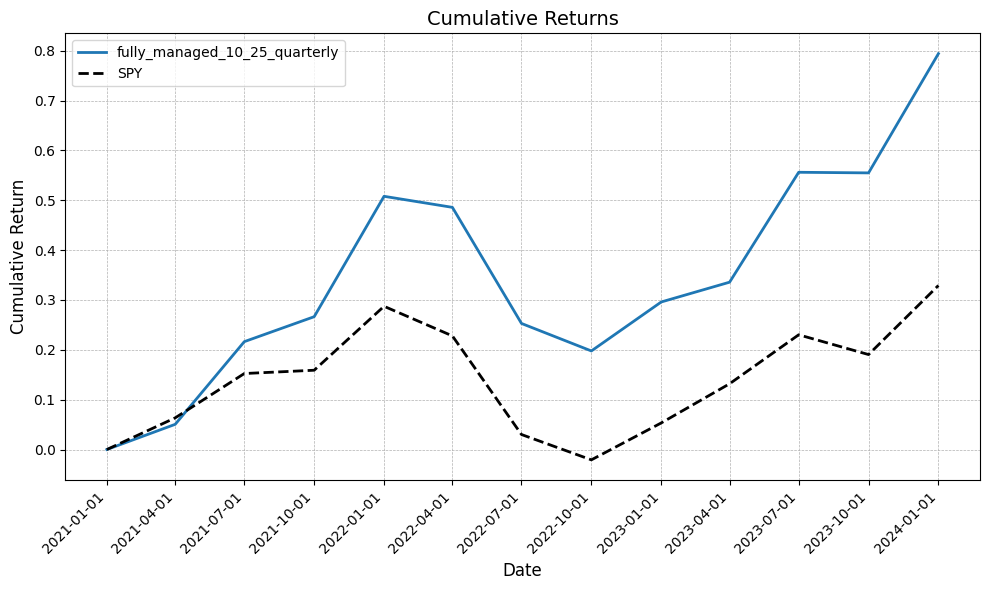

In [ ]:
# Cumulative returns of the baseline AI portfolio (GPT-4o, quarterly rebalance) vs. SPY
cumret_df, bm_cum_df = analyze_and_plot_cumulative_returns(
    portfolio_names=["fully_managed_10_25_quarterly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    aggregation="quarterly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
)

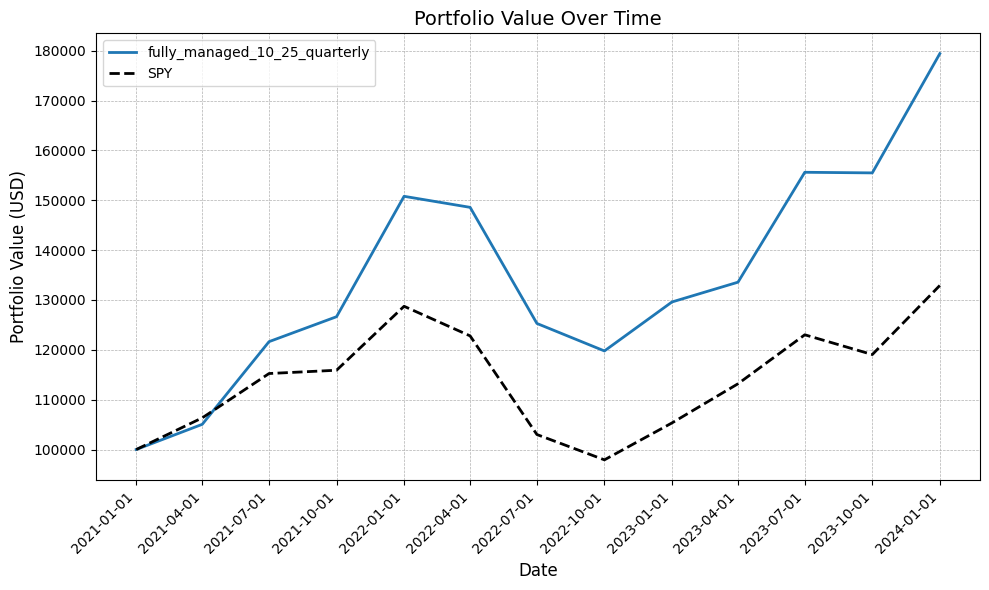

In [ ]:
# Value of the baseline AI portfolio (GPT-4o, quarterly rebalance) vs. SPY (scaled)
nav_df, bm_nav_df = analyze_and_plot_portfolio_values(
    portfolio_names=["fully_managed_10_25_quarterly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    aggregation="quarterly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
)

In [ ]:
# Performance metrics of the baseline AI portfolio (GPT-4o quarterly rebalance) vs. SPY
full_metrics = compute_performance_metrics(
    portfolio_names=["fully_managed_10_25_quarterly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly",
    rf_source="yield_3m",
    benchmark_ticker="SPY",
    benchmark_name="S&P 500 ETF",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,ann_return,ann_volatility,sharpe_ratio,max_drawdown,sortino_ratio,calmar_ratio
0,fully_managed_10_25_quarterly,0.22,0.20,0.93,-0.21,1.34,1.05
1,S&P 500 ETF,0.10,0.17,0.44,-0.24,0.63,0.42


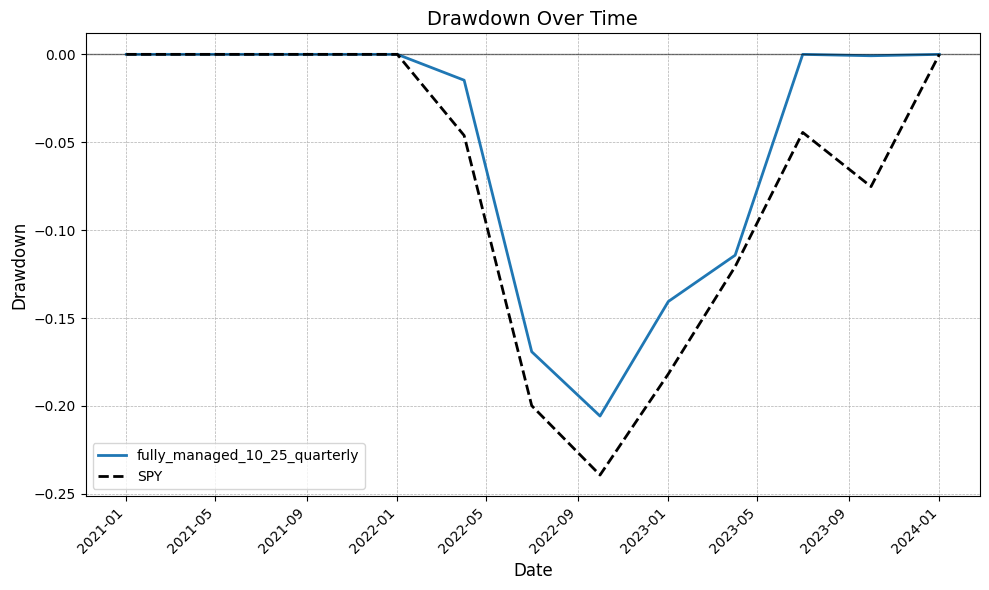

In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Drawdown vs. SPY
drawdown_df, bench_drawdown_df = analyze_and_plot_drawdowns(
    portfolio_names=["fully_managed_10_25_quarterly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    aggregation="quarterly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
)

## 4.1.2 Allocation Analysis

In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Allocation Metrics
full_metrics = compute_allocation_metrics(
    portfolio_names=["fully_managed_10_25_quarterly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="monthly",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,cash_pct,max_weight_pct,top5_weight_pct,hhi_assets,hhi_sectors,avg_turnover_pct
0,fully_managed_10_25_quarterly,0.46,15.0,57.0,1034.62,2487.08,19.54


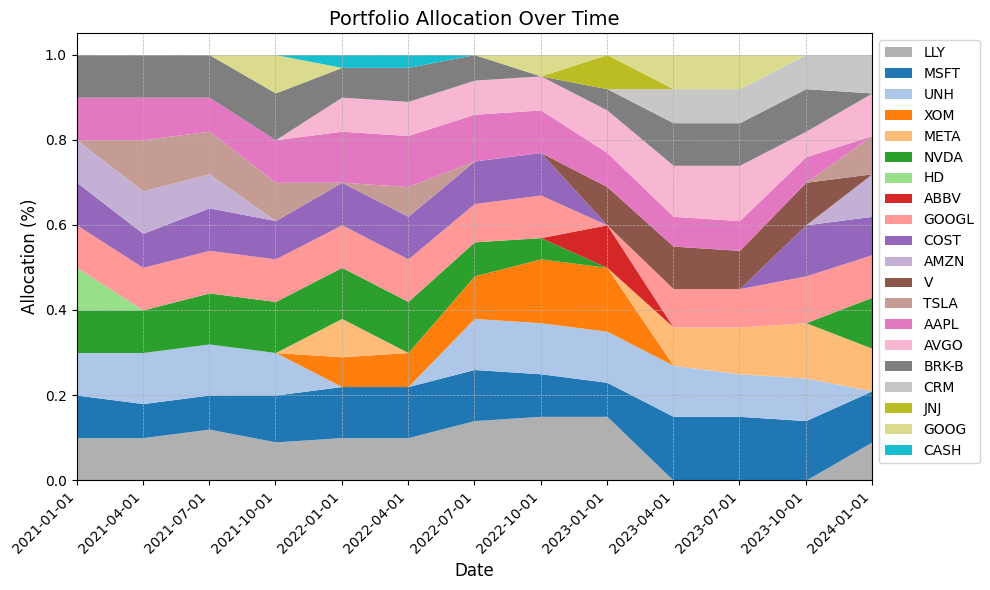

In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Allocation Over Time
alloc_df = compute_portfolio_allocation_over_time(
    portfolio_name="fully_managed_10_25_quarterly",
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly"
)
plot_portfolio_allocation_over_time(alloc_df, top_n=26)

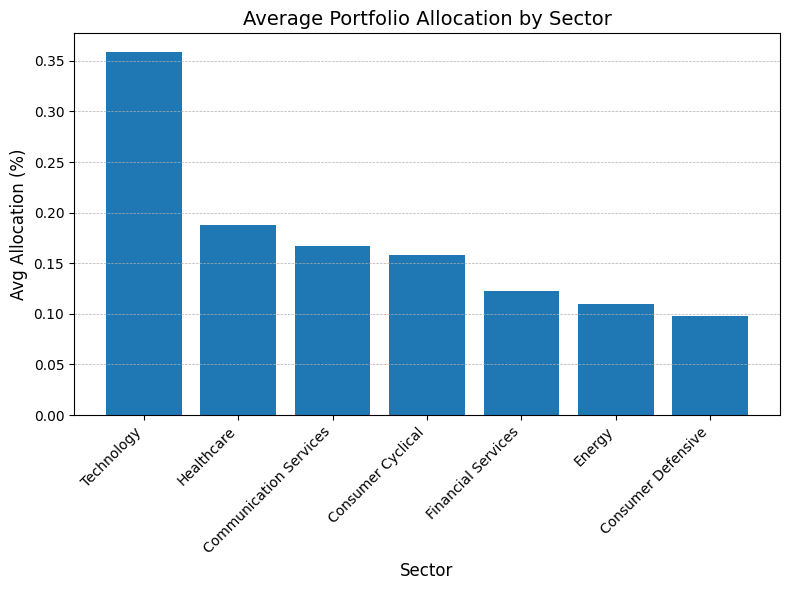

In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Average Sector Allocation
avg_sec_df = compute_average_sector_allocation(alloc_df)
plot_average_sector_allocation(avg_sec_df)

## 4.1.3 Market Regime Performance

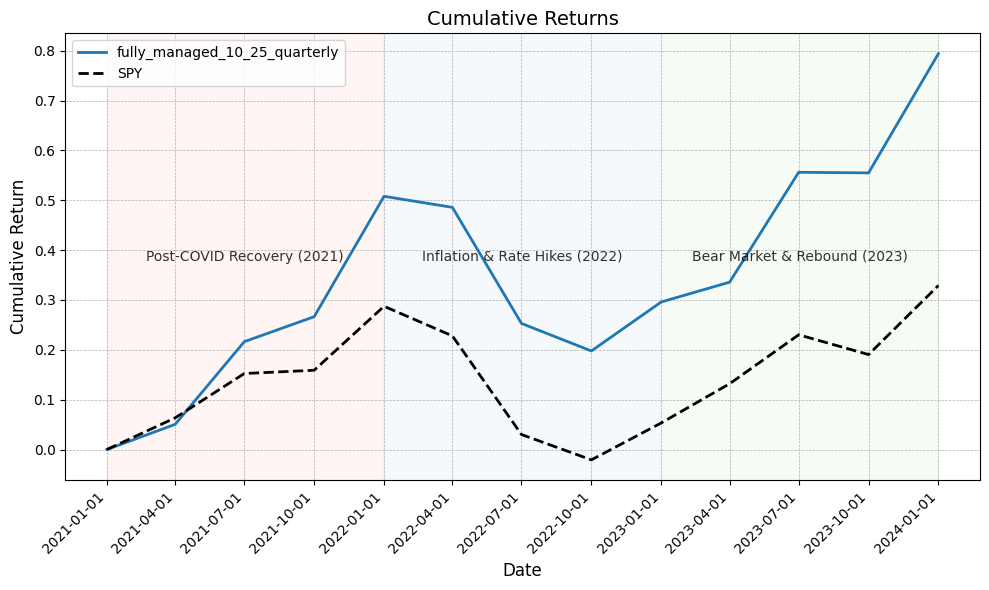

In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Cumulative Returns by Period vs. SPY
periods = [
  {"name":"Post-COVID Recovery (2021)",    "start":"2021-01-01","end":"2021-12-31","color":"#fde0dd"},
  {"name":"Inflation & Rate Hikes (2022)", "start":"2022-01-01","end":"2022-12-31","color":"#e0ecf4"},
  {"name":"Bear Market & Rebound (2023)",  "start":"2023-01-01","end":"2023-12-31","color":"#e5f5e0"},
]
port_cumret, benchmark_price_df = analyze_and_plot_cumulative_returns_by_periods(
   ["fully_managed_10_25_quarterly"],
   "2021-01-01","2024-01-01",
   periods=periods,
   aggregation="quarterly",
   benchmark_ticker="SPY"
)

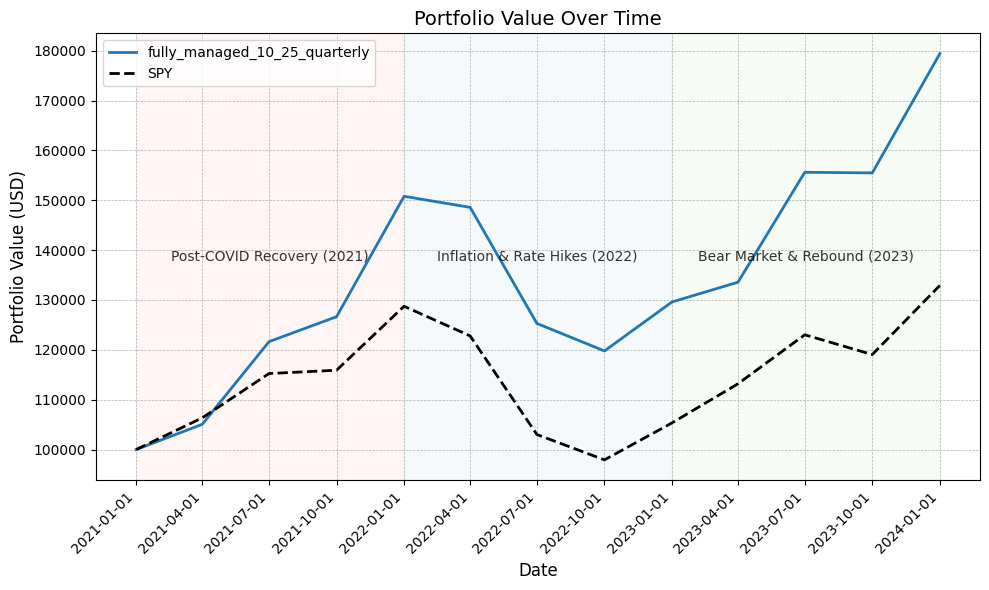

In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Value by Period vs. SPY
periods = [
  {"name":"Post-COVID Recovery (2021)",    "start":"2021-01-01","end":"2021-12-31","color":"#fde0dd"},
  {"name":"Inflation & Rate Hikes (2022)", "start":"2022-01-01","end":"2022-12-31","color":"#e0ecf4"},
  {"name":"Bear Market & Rebound (2023)",  "start":"2023-01-01","end":"2023-12-31","color":"#e5f5e0"},
]
nav_df, benchmark_price_df = analyze_and_plot_portfolio_values_by_periods(
   ["fully_managed_10_25_quarterly"],
   "2021-01-01","2024-01-01",
   periods=periods,
   aggregation="quarterly",
   benchmark_ticker="SPY"
)

In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Performance Metrics by Period vs. SPY
periods = [
    {"name":"Post-COVID Recovery",  "start":"2021-01-01","end":"2021-12-31"},
    {"name":"Inflation & Rate Hikes","start":"2022-01-01","end":"2022-12-31"},
    {"name":"Bear Market & Rebound",  "start":"2023-01-01","end":"2023-12-31"},
]
period_df = compute_performance_metrics_by_period(
    portfolio_names=["fully_managed_10_25_quarterly"],
    periods=periods,
    agg="quarterly",
    rf_source="yield_3m",
    benchmark_ticker="SPY",
    benchmark_name="S&P 500 ETF",
    db_path="aipm_thesis.db"
)
period_df

c:\Users\Ratko\Desktop\Projects\aipm-thesis\aipm-venv\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Ratko\Desktop\Projects\aipm-thesis\aipm-venv\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Ratko\Desktop\Projects\aipm-thesis\aipm-venv\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Ratko\Desktop\Projects\aipm-thesis\aipm-venv\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,portfolio_name,ann_return,ann_volatility,sharpe_ratio,max_drawdown,sortino_ratio,calmar_ratio,period
0,fully_managed_10_25_quarterly,0.37,0.13,2.85,0.00,NaN,NaN,Post-COVID Recovery
1,S&P 500 ETF,0.29,0.09,3.19,0.00,NaN,NaN,Post-COVID Recovery
2,fully_managed_10_25_quarterly,-0.26,0.15,-1.90,-0.21,-1.90,-1.29,Inflation & Rate Hikes
3,S&P 500 ETF,-0.18,0.19,-1.05,-0.24,-1.55,-0.76,Inflation & Rate Hikes
4,fully_managed_10_25_quarterly,0.27,0.18,1.26,-0.00,NaN,349.92,Bear Market & Rebound
5,S&P 500 ETF,0.26,0.13,1.61,-0.03,NaN,8.12,Bear Market & Rebound


In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Allocation Metrics by Period
periods = [
    {"name":"Post-COVID Recovery",  "start":"2021-01-01","end":"2021-12-31"},
    {"name":"Inflation & Rate Hikes","start":"2022-01-01","end":"2022-12-31"},
    {"name":"Bear Market & Rebound",  "start":"2023-01-01","end":"2023-12-31"},
]
compute_allocation_metrics_by_period(
    portfolio_names=["fully_managed_10_25_quarterly"],
    periods=periods,
    agg="quarterly",
    db_path="aipm_thesis.db"
)

,portfolio_name,cash_pct,max_weight_pct,top5_weight_pct,hhi_assets,hhi_sectors,avg_turnover_pct,period
0,fully_managed_10_25_quarterly,0.0,12.0,53.50,1012.5,2023.5,8.75,Post-COVID Recovery
1,fully_managed_10_25_quarterly,1.5,15.0,58.25,1031.0,2472.5,9.75,Inflation & Rate Hikes
2,fully_managed_10_25_quarterly,0.0,15.0,60.00,1066.0,2894.0,17.25,Bear Market & Rebound


## 4.2 Rebalancing-Frequency Impact

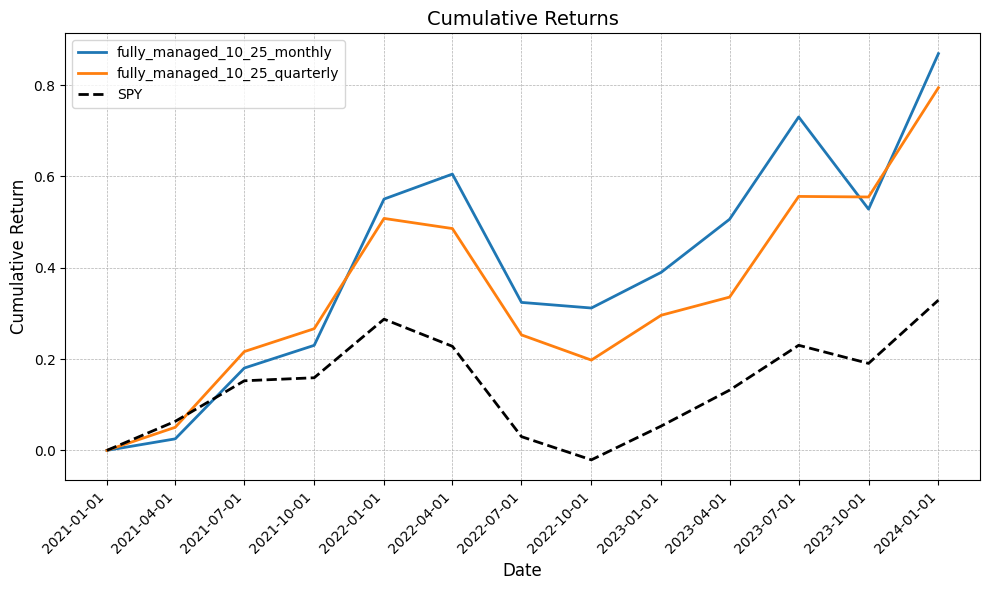

In [ ]:
# Quarterly vs. Monthly Rebalance Cumulative Returns vs. SPY
cumret_df, bm_cum_df = analyze_and_plot_cumulative_returns(
    portfolio_names=["fully_managed_10_25_quarterly", "fully_managed_10_25_monthly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    aggregation="quarterly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
)

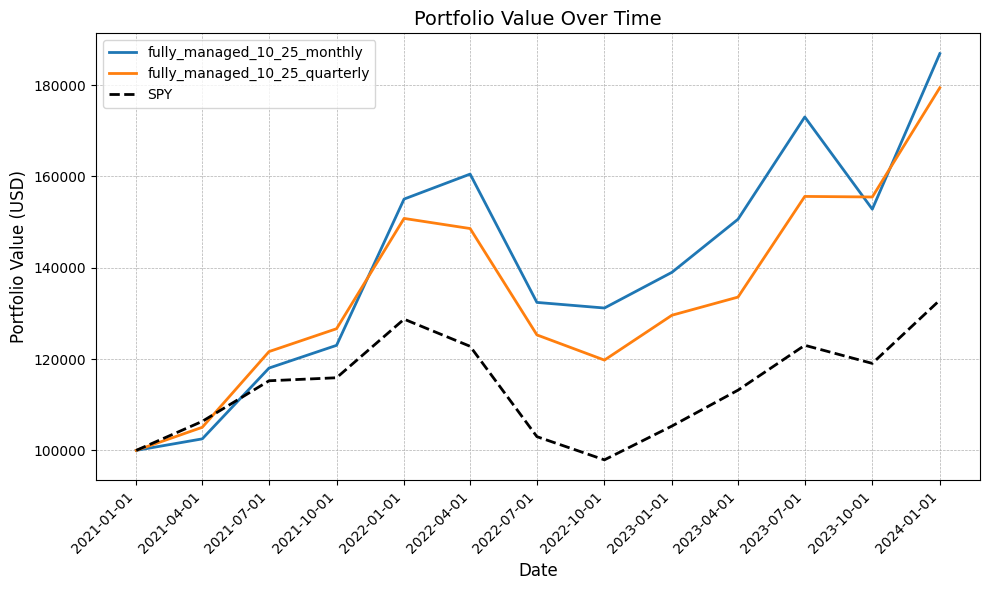

In [ ]:
# Quarterly vs. Monthly Rebalance Portfolio Value Over Time vs. SPY (Scaled)
nav_df, bm_nav_df = analyze_and_plot_portfolio_values(
    portfolio_names=["fully_managed_10_25_quarterly", "fully_managed_10_25_monthly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    aggregation="quarterly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
)

In [ ]:
# Quarterly vs. Monthly Rebalance Performance Metrics vs. SPY (Scaled)
full_metrics = compute_performance_metrics(
    portfolio_names=["fully_managed_10_25_quarterly", "fully_managed_10_25_monthly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly",
    rf_source="yield_3m",
    benchmark_ticker="SPY",
    benchmark_name="S&P 500 ETF",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,ann_return,ann_volatility,sharpe_ratio,max_drawdown,sortino_ratio,calmar_ratio
0,fully_managed_10_25_quarterly,0.22,0.20,0.93,-0.21,1.34,1.05
1,fully_managed_10_25_monthly,0.23,0.25,0.82,-0.18,1.23,1.27
2,S&P 500 ETF,0.10,0.17,0.44,-0.24,0.63,0.42


In [ ]:
# Baseline AI Portfolio (GPT-4o Quarterly Rebalance) Allocation Metrics
full_metrics = compute_allocation_metrics(
    portfolio_names=["fully_managed_10_25_monthly", "fully_managed_10_25_quarterly"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="monthly",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,cash_pct,max_weight_pct,top5_weight_pct,hhi_assets,hhi_sectors,avg_turnover_pct
0,fully_managed_10_25_monthly,1.61,19.0,60.39,1086.22,2358.25,17.61
1,fully_managed_10_25_quarterly,0.46,15.0,57.00,1034.62,2487.08,19.54


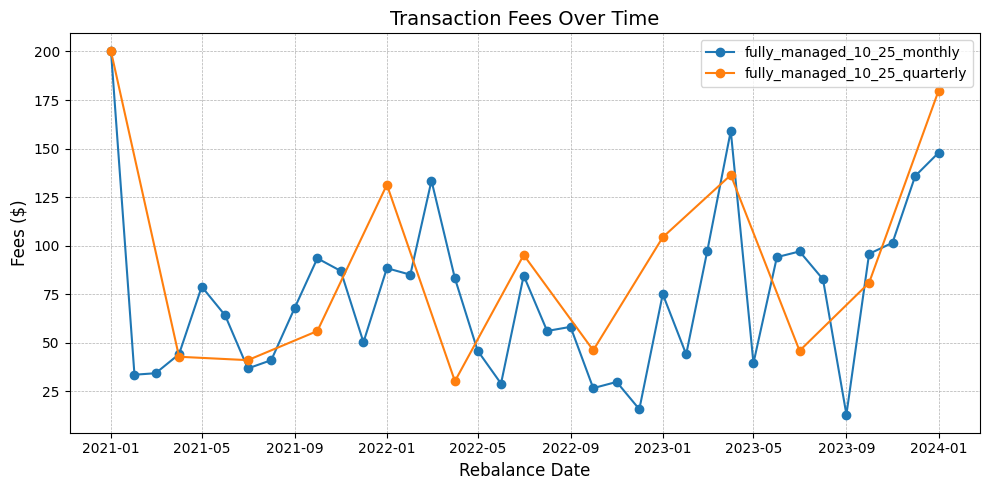

In [ ]:
# Quarterly vs. Monthly Rebalance Fees
fees_df = load_portfolio_fees(
    ["fully_managed_10_25_monthly","fully_managed_10_25_quarterly"],
    "2021-01-01","2024-01-01"
)
plot_fee_time_series(fees_df)

In [ ]:
# Quarterly vs. Monthly Rebalance Fee Metrics
fee_metrics = compute_fee_metrics(
    ["fully_managed_10_25_monthly","fully_managed_10_25_quarterly"],
    "2021-01-01","2024-01-01"
)
fee_metrics

,portfolio_name,rebalance_count,total_fees,avg_fee,avg_fee_pct
0,fully_managed_10_25_monthly,37,2753.06,74.41,0.05
1,fully_managed_10_25_quarterly,13,1190.89,91.61,0.07


## 4.3 Risk-Preference Impact

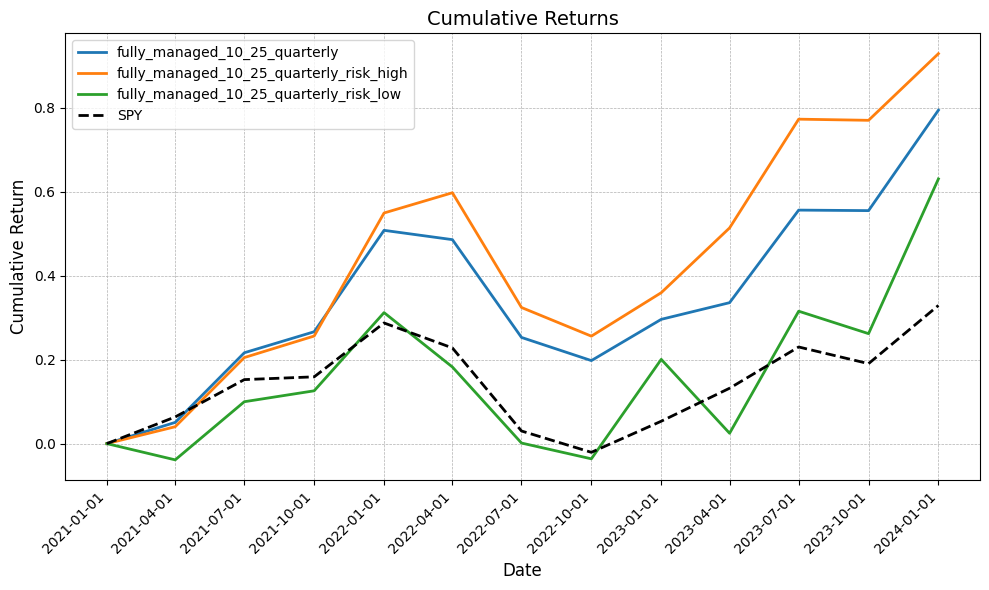

In [ ]:
# High vs. Normal vs. Low Risk Preference Portfolio Cumulative Returns vs. SPY
cumret_df, bm_cum_df = analyze_and_plot_cumulative_returns(
    portfolio_names=["fully_managed_10_25_quarterly_risk_high", "fully_managed_10_25_quarterly", "fully_managed_10_25_quarterly_risk_low"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    aggregation="quarterly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
)

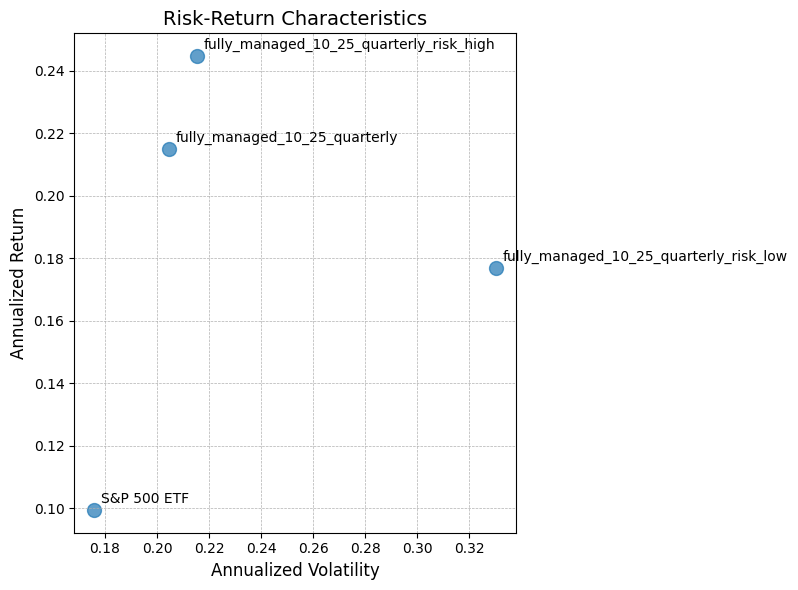

In [ ]:
# High vs. Normal vs. Low Risk Preference Portfolio Risk-Return Characteristics vs. SPY
metrics_df = analyze_and_plot_risk_return(
    portfolio_names   = [
        "fully_managed_10_25_quarterly_risk_high", 
        "fully_managed_10_25_quarterly", 
        "fully_managed_10_25_quarterly_risk_low"
    ],
    benchmark_ticker  = "SPY",
    benchmark_name    = "S&P 500 ETF",
    start_date        = "2021-01-01",
    end_date          = "2024-01-01",
    db_path           = "aipm_thesis.db",
    rf_source         = "yield_3m"
)

In [ ]:
# High vs. Normal vs. Low Risk Preference Performance Metrics vs. SPY
full_metrics = compute_performance_metrics(
    portfolio_names=[
        "fully_managed_10_25_quarterly_risk_high", 
        "fully_managed_10_25_quarterly", 
        "fully_managed_10_25_quarterly_risk_low"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly",
    rf_source="yield_3m",
    benchmark_ticker="SPY",
    benchmark_name="S&P 500 ETF",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,ann_return,ann_volatility,sharpe_ratio,max_drawdown,sortino_ratio,calmar_ratio
0,fully_managed_10_25_quarterly_risk_high,0.24,0.22,1.02,-0.21,1.26,1.14
1,fully_managed_10_25_quarterly,0.22,0.20,0.93,-0.21,1.34,1.05
2,fully_managed_10_25_quarterly_risk_low,0.18,0.33,0.46,-0.27,1.39,0.67
3,S&P 500 ETF,0.10,0.17,0.44,-0.24,0.63,0.42


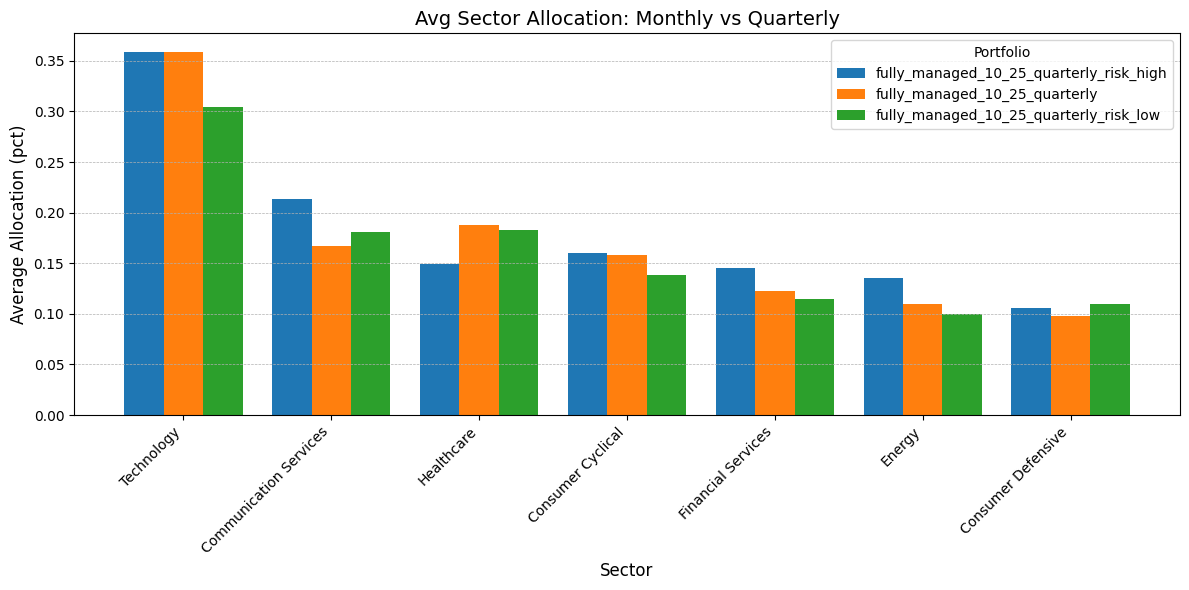

In [ ]:
# High vs. Normal vs. Low Risk Preference Portfolio Average Sector Allocation
avg_sec_df = compute_average_sector_allocation_multiple(
    portfolio_names=[
        "fully_managed_10_25_quarterly_risk_high", 
        "fully_managed_10_25_quarterly", 
        "fully_managed_10_25_quarterly_risk_low"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly",
    db_path="aipm_thesis.db"
)

# plot them grouped by sector
plot_average_sector_allocation_grouped(
    avg_sector_multi_df=avg_sec_df,
    title="Avg Sector Allocation: Monthly vs Quarterly"
)

In [ ]:
# High vs. Normal vs. Low Risk Preference Portfolio Allocation Metrics
full_metrics = compute_allocation_metrics(
    portfolio_names=[
        "fully_managed_10_25_quarterly_risk_high", 
        "fully_managed_10_25_quarterly", 
        "fully_managed_10_25_quarterly_risk_low"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="monthly",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,cash_pct,max_weight_pct,top5_weight_pct,hhi_assets,hhi_sectors,avg_turnover_pct
0,fully_managed_10_25_quarterly_risk_high,0.00,18.0,56.62,1049.54,2560.46,21.92
1,fully_managed_10_25_quarterly,0.46,15.0,57.00,1034.62,2487.08,19.54
2,fully_managed_10_25_quarterly_risk_low,11.69,20.0,56.85,1056.62,2046.92,24.15


## 4.4 Sector Preference Impact

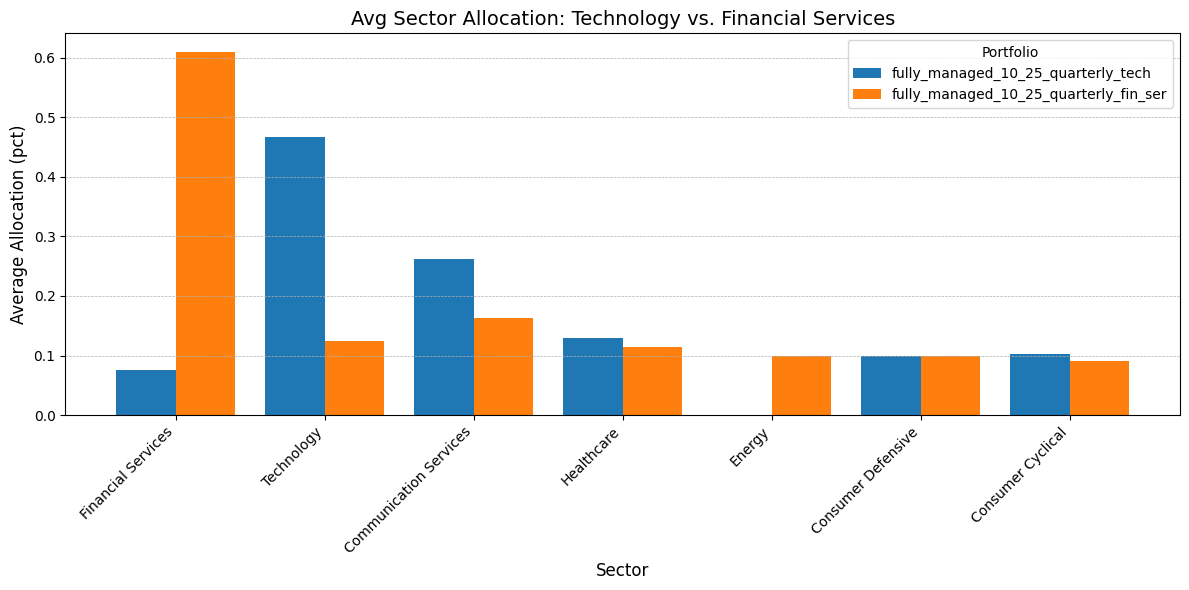

In [ ]:
# "Technology" vs. "Financial Services" Sector Preference Portfolio Average Sector Allocation
avg_sec_df = compute_average_sector_allocation_multiple(
    portfolio_names=[
        "fully_managed_10_25_quarterly_tech", 
        "fully_managed_10_25_quarterly_fin_ser"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly",
    db_path="aipm_thesis.db"
)

# plot them grouped by sector
plot_average_sector_allocation_grouped(
    avg_sector_multi_df=avg_sec_df,
    title="Avg Sector Allocation: Technology vs. Financial Services"
)

In [ ]:
# "Technology" vs. "Financial Services" Sector Preference Portfolio Allocation Metrics
full_metrics = compute_allocation_metrics(
    portfolio_names=[
        "fully_managed_10_25_quarterly_tech", 
        "fully_managed_10_25_quarterly_fin_ser"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="monthly",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,cash_pct,max_weight_pct,top5_weight_pct,hhi_assets,hhi_sectors,avg_turnover_pct
0,fully_managed_10_25_quarterly_tech,0.15,21.0,59.23,1088.15,3288.92,18.15
1,fully_managed_10_25_quarterly_fin_ser,3.15,21.0,70.62,1324.77,4764.08,23.00


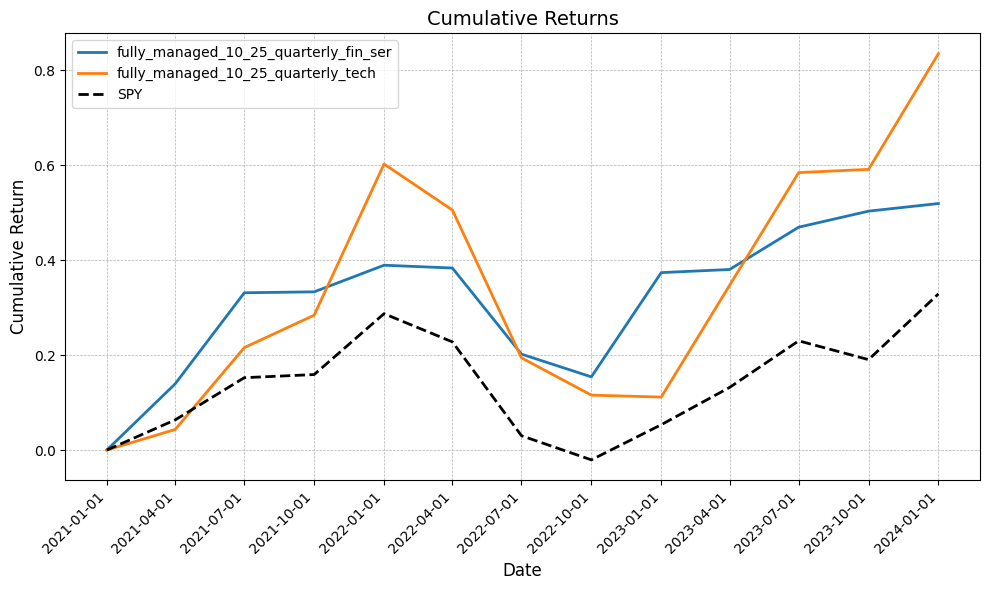

In [ ]:
# "Technology" vs. "Financial Services" Sector Preference Cumulative Returns vs. SPY
cumret_df, bm_cum_df = analyze_and_plot_cumulative_returns(
    portfolio_names=[
        "fully_managed_10_25_quarterly_tech", 
        "fully_managed_10_25_quarterly_fin_ser"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    aggregation="quarterly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
)

In [ ]:
# "Technology" vs. "Financial Services" Sector Preference Performance Metrics vs. SPY
full_metrics = compute_performance_metrics(
    portfolio_names=["fully_managed_10_25_quarterly_tech", "fully_managed_10_25_quarterly_fin_ser"],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly",
    rf_source="yield_3m",
    benchmark_ticker="SPY",
    benchmark_name="S&P 500 ETF",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,ann_return,ann_volatility,sharpe_ratio,max_drawdown,sortino_ratio,calmar_ratio
0,fully_managed_10_25_quarterly_tech,0.22,0.27,0.74,-0.31,1.15,0.73
1,fully_managed_10_25_quarterly_fin_ser,0.15,0.18,0.69,-0.17,0.95,0.88
2,S&P 500 ETF,0.10,0.17,0.44,-0.24,0.63,0.42


## 4.5 Model Impact Analysis

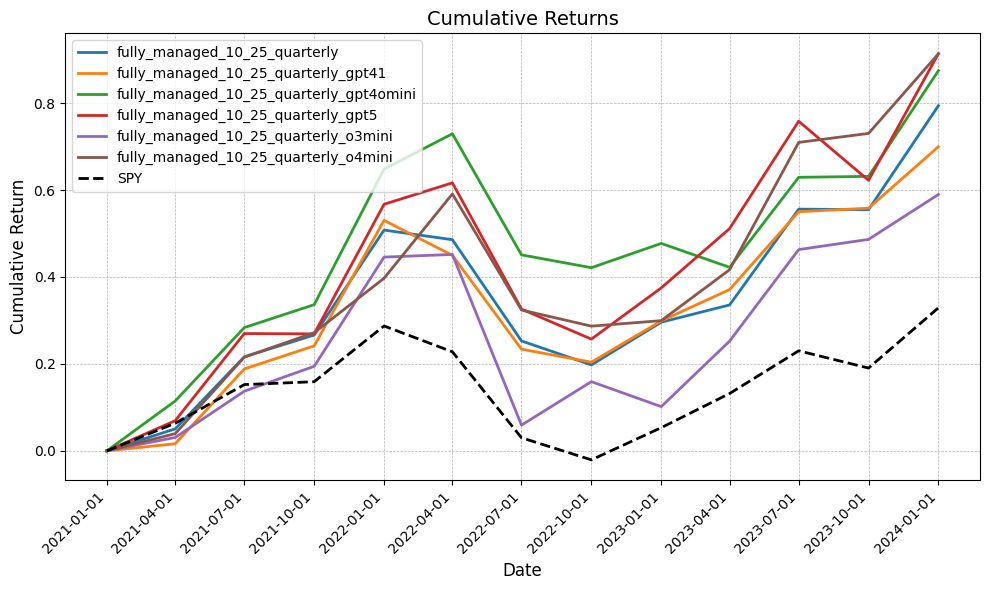

In [ ]:
# Portfolios Managed by Different LLMs (GPT-4o is Baseline) Cumulative Returns vs. SPY
cumret_df, bm_cum_df = analyze_and_plot_cumulative_returns(
    portfolio_names=[
    "fully_managed_10_25_quarterly",
    "fully_managed_10_25_quarterly_gpt41",
    "fully_managed_10_25_quarterly_gpt4omini",
    "fully_managed_10_25_quarterly_o3mini",
    "fully_managed_10_25_quarterly_o4mini",
    "fully_managed_10_25_quarterly_gpt5"
],
    start_date="2021-01-01",
    end_date="2024-01-01",
    aggregation="quarterly",
    benchmark_ticker="SPY",
    db_path="aipm_thesis.db"
)

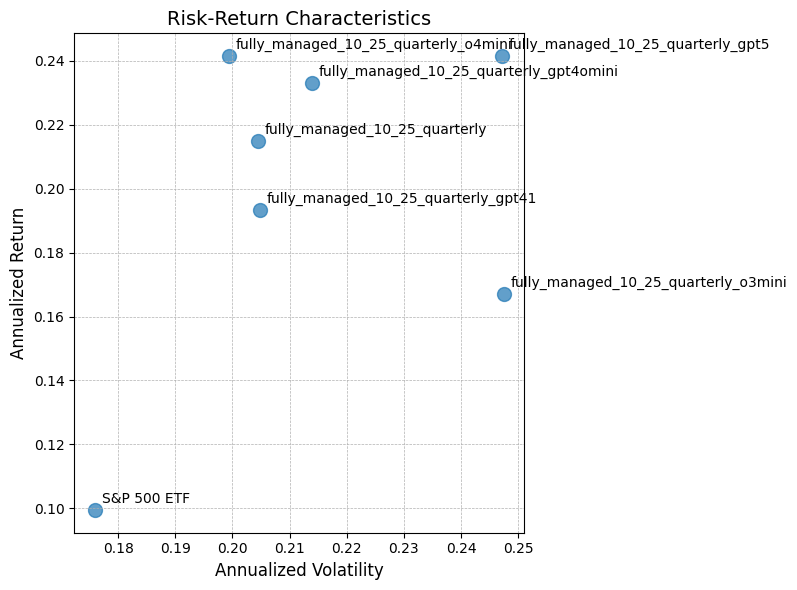

In [ ]:
# Portfolios Managed by Different LLMs (GPT-4o is Baseline) Risk-Return Characteristics vs. SPY
metrics_df = analyze_and_plot_risk_return(
    portfolio_names   = [
    "fully_managed_10_25_quarterly",
    "fully_managed_10_25_quarterly_gpt41",
    "fully_managed_10_25_quarterly_gpt4omini",
    "fully_managed_10_25_quarterly_o3mini",
    "fully_managed_10_25_quarterly_o4mini",
    "fully_managed_10_25_quarterly_gpt5"
],
    benchmark_ticker  = "SPY",
    benchmark_name    = "S&P 500 ETF",
    start_date        = "2021-01-01",
    end_date          = "2024-01-01",
    db_path           = "aipm_thesis.db",
    rf_source         = "yield_3m"
)

In [ ]:
# Portfolios Managed by Different LLMs (GPT-4o is Baseline) Performance Metrics vs. SPY
full_metrics = compute_performance_metrics(
    portfolio_names=[
        "fully_managed_10_25_quarterly",
        "fully_managed_10_25_quarterly_gpt41",
        "fully_managed_10_25_quarterly_gpt4omini",
        "fully_managed_10_25_quarterly_o3mini",
        "fully_managed_10_25_quarterly_o4mini",
        "fully_managed_10_25_quarterly_gpt5"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly",
    rf_source="yield_3m",
    benchmark_ticker="SPY",
    benchmark_name="S&P 500 ETF",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,ann_return,ann_volatility,sharpe_ratio,max_drawdown,sortino_ratio,calmar_ratio
0,fully_managed_10_25_quarterly,0.22,0.20,0.93,-0.21,1.34,1.05
1,fully_managed_10_25_quarterly_gpt41,0.19,0.20,0.82,-0.21,1.29,0.91
2,fully_managed_10_25_quarterly_gpt4omini,0.23,0.21,0.97,-0.18,1.35,1.31
3,fully_managed_10_25_quarterly_o3mini,0.17,0.25,0.57,-0.27,0.46,0.62
4,fully_managed_10_25_quarterly_o4mini,0.24,0.20,1.09,-0.19,1.10,1.26
5,fully_managed_10_25_quarterly_gpt5,0.24,0.25,0.88,-0.22,1.44,1.09
6,S&P 500 ETF,0.10,0.17,0.44,-0.24,0.63,0.42


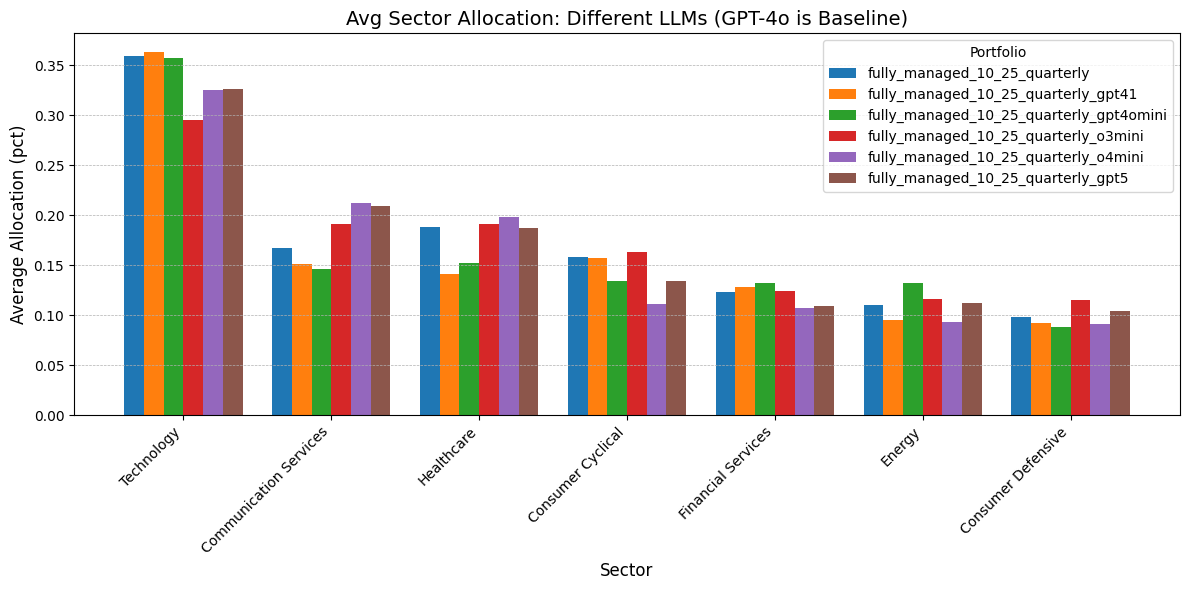

In [ ]:
# Portfolios Managed by Different LLMs (GPT-4o is Baseline) Average Sector Allocation
avg_sec_df = compute_average_sector_allocation_multiple(
    portfolio_names=[
        "fully_managed_10_25_quarterly",
        "fully_managed_10_25_quarterly_gpt41",
        "fully_managed_10_25_quarterly_gpt4omini",
        "fully_managed_10_25_quarterly_o3mini",
        "fully_managed_10_25_quarterly_o4mini",
        "fully_managed_10_25_quarterly_gpt5"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="quarterly",
    db_path="aipm_thesis.db"
)

# plot them grouped by sector
plot_average_sector_allocation_grouped(
    avg_sector_multi_df=avg_sec_df,
    title="Avg Sector Allocation: Different LLMs (GPT-4o is Baseline)"
)

In [ ]:
# Portfolios Managed by Different LLMs (GPT-4o is Baseline) Allocation Metrics
full_metrics = compute_allocation_metrics(
    portfolio_names=[
        "fully_managed_10_25_quarterly",
        "fully_managed_10_25_quarterly_gpt41",
        "fully_managed_10_25_quarterly_gpt4omini",
        "fully_managed_10_25_quarterly_o3mini",
        "fully_managed_10_25_quarterly_o4mini",
        "fully_managed_10_25_quarterly_gpt5"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    agg="monthly",
    db_path="aipm_thesis.db"
)
full_metrics

,portfolio_name,cash_pct,max_weight_pct,top5_weight_pct,hhi_assets,hhi_sectors,avg_turnover_pct
0,fully_managed_10_25_quarterly,0.46,15.0,57.00,1034.62,2487.08,19.54
1,fully_managed_10_25_quarterly_gpt41,0.62,20.0,59.18,1063.61,2365.53,20.30
2,fully_managed_10_25_quarterly_gpt4omini,3.38,20.0,58.69,1068.15,2274.92,18.85
3,fully_managed_10_25_quarterly_o3mini,2.15,20.0,55.08,1052.15,2198.62,17.69
4,fully_managed_10_25_quarterly_o4mini,0.85,16.0,56.54,1039.23,2454.38,18.00
5,fully_managed_10_25_quarterly_gpt5,3.61,16.0,56.97,1051.48,2357.41,19.60


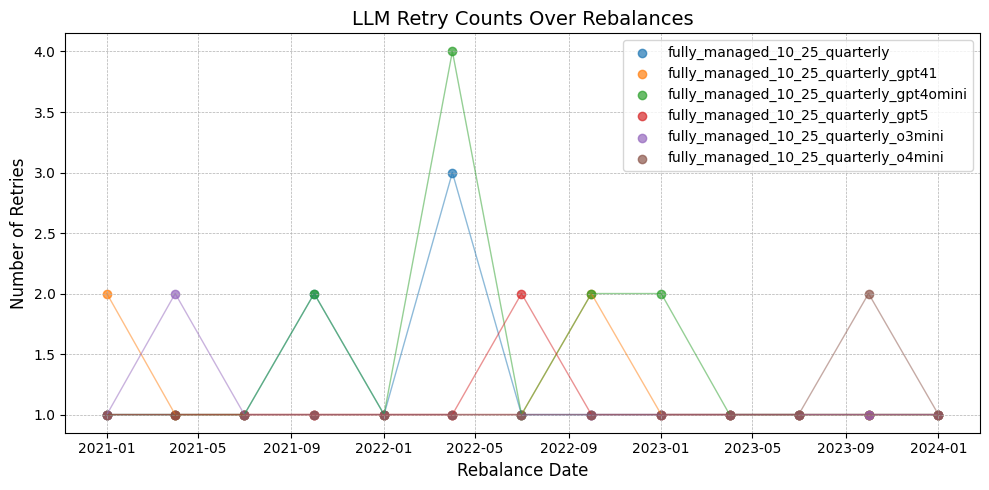

In [ ]:
# API Call Retry Counts (Constraints Violations) by LLM
retries_df = load_portfolio_retries(
    portfolio_names=[
        "fully_managed_10_25_quarterly",
        "fully_managed_10_25_quarterly_gpt41",
        "fully_managed_10_25_quarterly_gpt4omini",
        "fully_managed_10_25_quarterly_o3mini",
        "fully_managed_10_25_quarterly_o4mini",
        "fully_managed_10_25_quarterly_gpt5"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    db_path="aipm_thesis.db"
)
plot_retry_time_series(retries_df)

In [ ]:
# API Call Retry (Constraints Violations) Metrics by LLM
retries_df = load_portfolio_retries(
    portfolio_names=[
        "fully_managed_10_25_quarterly",
        "fully_managed_10_25_quarterly_gpt41",
        "fully_managed_10_25_quarterly_gpt4omini",
        "fully_managed_10_25_quarterly_o3mini",
        "fully_managed_10_25_quarterly_o4mini",
        "fully_managed_10_25_quarterly_gpt5"
    ],
    start_date="2021-01-01",
    end_date="2024-01-01",
    db_path="aipm_thesis.db"
)
rel_metrics = compute_reliability_metrics(retries_df)
rel_metrics

,portfolio_name,total_events,first_try_success_pct,avg_retries,max_retries
0,fully_managed_10_25_quarterly,13,84.62,1.23,3
1,fully_managed_10_25_quarterly_gpt41,13,84.62,1.15,2
2,fully_managed_10_25_quarterly_gpt4omini,13,69.23,1.46,4
3,fully_managed_10_25_quarterly_gpt5,13,92.31,1.08,2
4,fully_managed_10_25_quarterly_o3mini,13,92.31,1.08,2
5,fully_managed_10_25_quarterly_o4mini,13,92.31,1.08,2


# **DB Query Examples**

In [ ]:
# Get all tables in the database
import sqlite3

conn = sqlite3.connect('aipm_thesis.db')
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table in tables:
    print(table[0])

conn.close()

In [ ]:
# Get all sector information - see which tickers are available for analysis
import sqlite3
import pandas as pd


conn = sqlite3.connect('aipm_thesis.db')
query = "SELECT * FROM sector_information"
df = pd.read_sql_query(query, conn)
conn.close()
df

In [ ]:
# Get all portfolio names
import sqlite3
import pandas as pd

conn = sqlite3.connect('aipm_thesis.db')
query = "SELECT DISTINCT portfolio_name FROM portfolio"
df = pd.read_sql_query(query, conn)
conn.close()
df

In [ ]:
# Get all states for a single portfolio
import sqlite3
import pandas as pd

conn = sqlite3.connect('aipm_thesis.db')
query = "SELECT * FROM portfolio WHERE portfolio_name = 'fully_managed_10_25_quarterly'"
df = pd.read_sql_query(query, conn)
conn.close()
df

In [ ]:
# Print portfolio state at a specific date
import sqlite3
import pandas as pd

conn = sqlite3.connect('aipm_thesis.db')
query = "SELECT * FROM portfolio WHERE portfolio_name = 'fully_managed_10_25_quarterly'"
df = pd.read_sql_query(query, conn)
conn.close()
df
print(df[df["date"] == "2021-01-01"]["state"].values[0])

In [ ]:
# See prices data
import sqlite3
import pandas as pd

conn = sqlite3.connect('aipm_thesis.db')
query = "SELECT * FROM stock_prices_daily"
df = pd.read_sql_query(query, conn)
conn.close()
df

In [ ]:
# See sentiment data
import sqlite3
import pandas as pd

conn = sqlite3.connect('aipm_thesis.db')
query = "SELECT * FROM sentiment_monthly"
df = pd.read_sql_query(query, conn)
conn.close()
df

In [ ]:
# See agents' analysis outputs for a specific date
import sqlite3
import pandas as pd

conn = sqlite3.connect('aipm_thesis.db')
query = "SELECT * FROM analysis_outputs"
df = pd.read_sql_query(query, conn)
conn.close()
df
print(df[df['date'] == '2021-01-01']['analysis_output'].values[0])

In [ ]:
# Delete rows from portfolio table
# import sqlite3

# # Path to your SQLite database
# db_path = "aipm_thesis.db"

# # Connect to the database
# conn = sqlite3.connect(db_path)
# cursor = conn.cursor()

# # Optional: Preview rows before deletion
# cursor.execute("""
# SELECT *
# FROM portfolio
# WHERE portfolio_name = 'fully_managed_10_25_quarterly_o4mini'
# """)
# rows = cursor.fetchall()
# print("Rows to be deleted:", rows)

# # Delete rows
# cursor.execute("""
# DELETE FROM portfolio
# WHERE portfolio_name = 'fully_managed_10_25_quarterly_o4mini'
# """)

# # Commit changes and close connection
# conn.commit()
# conn.close()

# print("Rows deleted successfully.")